In [1]:
from functools import partial

import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime

from timm.models.vision_transformer import Block
from model_mae import MaskedAutoencoder
from utils import MaskEmbed, get_1d_sincos_pos_embed, ActiveEmbed, Utils

eps = 1e-6

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')

In [3]:
device

device(type='cuda', index=2)

In [4]:
path = "."
filename = "TransferLearningData.csv"
model_dir = "./model/"
log_dir = "./log/"

In [5]:
# Supply the wandb parameters, like project, run name
wandb_project = "mae"
wandb_run = "run_without_mendota_{}_{}".format(str(datetime.datetime.now().date()), str(datetime.datetime.now().time()))
save_code = True

In [6]:
pre_train_window = 35
non_null_ratio = 0.20

'''
learning rate scheduler parameters
'''
max_lr=5e-2
div_factor=100
pct_start=0.05 
anneal_strategy='cos'
final_div_factor=10000.0

In [7]:
filepath = os.path.join(path, filename)
df = pd.read_csv(filepath)

/tmp/ipykernel_37295/1025252231.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [8]:
df

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,21.69000,2.576500,0.001250,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,21.19500,1.132500,0.003451,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,20.29000,1.154821,0.005080,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,23.55500,1.177141,0.003196,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,24.73000,1.199462,0.001073,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70835,TOOK,2022-12-27,buoy,0.5,observed,NaN,-35.39290,-0.740000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70836,TOOK,2022-12-28,buoy,0.5,observed,NaN,-29.69685,0.575000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70837,TOOK,2022-12-29,buoy,0.5,observed,NaN,-22.03290,-0.675000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70838,TOOK,2022-12-30,buoy,0.5,observed,NaN,-13.60220,-0.980000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN


In [9]:
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [10]:
cols_to_exclude_from_features = ["Lake","Site","Depth_m","DataType","ModelRunType"]
features_col = df.columns.difference(cols_to_exclude_from_features)
features_col = [feat for feat in features_col if not 'flag' in feat.lower() and feat!='DateTime']
features_col

['AirTemp_C',
 'Chla_ugL',
 'DIN_ugL',
 'Inflow_cms',
 'LightAttenuation_Kd',
 'SRP_ugL',
 'Shortwave_Wm2',
 'WaterTemp_C']

In [11]:
# df = df.dropna(subset=features_col)
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [12]:
for lake in df.Lake.unique():
    lake_df = df[df['Lake']==lake]
    print(f"Lake {lake} has types = {lake_df.DataType.unique()}")

Lake FCR has types = ['observed' 'modeled']
Lake Mendota has types = ['modeled']
Lake Sunapee has types = ['modeled']
Lake BARC has types = ['observed']
Lake CRAM has types = ['observed']
Lake LIRO has types = ['observed']
Lake PRLA has types = ['observed']
Lake PRPO has types = ['observed']
Lake SUGG has types = ['observed']
Lake TOOK has types = ['observed']


In [13]:
date_col = ['DateTime']
date_col

['DateTime']

In [14]:
df.DateTime = df.DateTime.astype('datetime64[ns]')

In [15]:
# get the observed values
train_df = df.copy(deep=True)

In [16]:
flag_cols = [col for col in train_df.columns if col.startswith('Flag')]

In [17]:
target_col_ind = features_col.index('Chla_ugL')
target_col_ind

1

In [18]:
num_features = len(features_col)
utils = Utils(num_features=num_features,
              inp_cols=features_col, 
              date_col=date_col, 
              window=pre_train_window, 
              flag_cols=flag_cols,
              non_null_ratio=non_null_ratio,
              device=device,
              stride=1)

In [19]:
train_df = train_df[train_df['Lake']!='Mendota'].reset_index(drop='true')

In [20]:
train_set = pd.DataFrame()
val_set = pd.DataFrame()

for lake in train_df.Lake.unique():
    lake_df = train_df[train_df['Lake']==lake].reset_index(drop='true')
    types = lake_df.DataType.unique()
    for dtype in types:
        lake_type_df = lake_df[lake_df['DataType']==dtype].reset_index(drop='true')
        train, val = utils.train_test_split(lake_type_df, split_type=None, split_date=None, split_ratio=0.8)
        train_set = train_set.append(train, ignore_index=True)
        val_set = val_set.append(val, ignore_index=True)

/tmp/ipykernel_37295/3497671915.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(train, ignore_index=True)
/tmp/ipykernel_37295/3497671915.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_set = val_set.append(val, ignore_index=True)


In [21]:
train_set = utils.normalize(train_set)
val_set = utils.normalize(val_set, use_stat=True)

In [22]:
print(utils.feat_std, utils.feat_mean)

11.632701089031507 8.77956916447641


In [23]:
load=True

In [26]:
if load:
    train_X = torch.load('without_mendota_train_X.pth')
    val_X = torch.load('without_mendota_val_X.pth')
else:
    train_X = utils.windowed_dataset_utils(train_set)
    val_X = utils.windowed_dataset_utils(val_set)

    torch.save(train_X, "without_mendota_train_X.pth")
    torch.save(val_X, "without_mendota_val_X.pth")

In [27]:
train_X = torch.from_numpy(train_X).type(torch.Tensor)
val_X = torch.from_numpy(val_X).type(torch.Tensor)

In [28]:
train_X.shape

torch.Size([24625, 35, 8])

In [29]:
val_X.shape

torch.Size([6106, 35, 8])

In [30]:
from datasets import load_dataset

In [31]:
model_args = {
    'num_feats':num_features,
    'rec_len': pre_train_window,
    'embed_dim': 64,
    'depth': 2,
    'num_heads': 4,
    'decoder_embed_dim':32,
    'decoder_depth':2,
    'decoder_num_heads':4,
    'mlp_ratio':4,
    'norm_layer':partial(nn.LayerNorm, eps=eps),
    'mask_ratio':0.5
}
train_args = {
    'batch_size':32,
    'accum_iter':1,
    'min_lr':1e-5,
    'weight_decay':0.05,
    'lr': None,
    'blr': 1e-2,
    'warmup_epochs':10, #40
    'max_epochs': 100, #600
    'device':device,
    'project_name': wandb_project,
    'run_name': wandb_run,
    'save_code': save_code,
    'eval_freq':1,
    'target_col_ind':target_col_ind,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor
}

In [32]:
config= {**model_args, **train_args}

In [33]:
model = MaskedAutoencoder(utils, **model_args)

In [34]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[2], train_X.shape[1])
val_X = val_X.reshape(val_X.shape[0], val_X.shape[2], val_X.shape[1])

In [35]:
train_X.shape, val_X.shape

(torch.Size([24625, 8, 35]), torch.Size([6106, 8, 35]))

In [36]:
wandb_run

'run_without_mendota_2023-11-20_02:17:10.781624'

In [37]:
history = model.train_model(train_X, val_X, config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aneog. Use `wandb login --relogin` to force relogin


  0%|                                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

learning rate in epoch 0 = [0.0005000000000000004] 



0it [00:00, ?it/s]/home/abhilash22/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

1it [00:00,  4.42it/s]
6it [00:00, 20.46it/s]
10it [00:00, 25.98it/s]
14it [00:00, 29.99it/s]
18it [00:00, 32.16it/s]
22it [00:00, 33.81it/s]
26it [00:00, 34.75it/s]
30it [00:01, 35.12it/s]
34it [00:01, 35.44it/s]
38it [00:01, 35.49it/s]
42it [00:01, 35.77it/s]
46it [00:01, 36.12it/s]
50it [00:01, 36.15it/s]
54it [00:01, 35.79it/s]
58it [00:01, 35.96it/s]
62it [00:01, 36.02it/s]
66it [00:02, 35.65it/s]
70it [00:02, 36.

learning rate in epoch 1 = [0.005229204449466472] 



0it [00:00, ?it/s]
4it [00:00, 34.47it/s]
8it [00:00, 35.29it/s]
12it [00:00, 35.46it/s]
16it [00:00, 35.54it/s]
20it [00:00, 35.82it/s]
24it [00:00, 36.36it/s]
28it [00:00, 36.55it/s]
32it [00:00, 36.64it/s]
36it [00:00, 36.57it/s]
40it [00:01, 36.55it/s]
44it [00:01, 36.48it/s]
48it [00:01, 36.61it/s]
52it [00:01, 35.81it/s]
56it [00:01, 36.14it/s]
60it [00:01, 36.18it/s]
64it [00:01, 36.57it/s]
68it [00:01, 36.76it/s]
72it [00:01, 36.58it/s]
76it [00:02, 36.71it/s]
80it [00:02, 36.28it/s]
84it [00:02, 36.30it/s]
88it [00:02, 36.28it/s]
92it [00:02, 36.49it/s]
96it [00:02, 36.75it/s]
100it [00:02, 36.66it/s]
104it [00:02, 36.79it/s]
108it [00:02, 36.81it/s]
112it [00:03, 36.52it/s]
116it [00:03, 36.34it/s]
120it [00:03, 36.93it/s]
124it [00:03, 36.83it/s]
128it [00:03, 36.62it/s]
132it [00:03, 36.85it/s]
136it [00:03, 36.68it/s]
140it [00:03, 36.82it/s]
144it [00:03, 37.02it/s]
148it [00:04, 37.01it/s]
152it [00:04, 36.74it/s]
156it [00:04, 36.74it/s]
160it [00:04, 36.74it/s]
164it 

learning rate in epoch 2 = [0.017609514789796915] 



0it [00:00, ?it/s]
4it [00:00, 35.59it/s]
8it [00:00, 37.58it/s]
12it [00:00, 37.76it/s]
17it [00:00, 39.33it/s]
22it [00:00, 39.55it/s]
26it [00:00, 38.64it/s]
30it [00:00, 38.91it/s]
34it [00:00, 38.53it/s]
38it [00:00, 38.63it/s]
42it [00:01, 38.69it/s]
46it [00:01, 38.23it/s]
50it [00:01, 37.50it/s]
54it [00:01, 37.84it/s]
58it [00:01, 37.52it/s]
62it [00:01, 37.72it/s]
66it [00:01, 37.25it/s]
70it [00:01, 37.44it/s]
74it [00:01, 37.70it/s]
78it [00:02, 37.71it/s]
82it [00:02, 37.18it/s]
86it [00:02, 37.03it/s]
90it [00:02, 36.51it/s]
94it [00:02, 36.17it/s]
98it [00:02, 36.16it/s]
102it [00:02, 36.24it/s]
106it [00:02, 36.52it/s]
110it [00:02, 36.65it/s]
114it [00:03, 36.84it/s]
118it [00:03, 36.77it/s]
122it [00:03, 36.60it/s]
126it [00:03, 35.88it/s]
130it [00:03, 36.00it/s]
134it [00:03, 35.52it/s]
138it [00:03, 35.08it/s]
142it [00:03, 34.82it/s]
146it [00:03, 34.98it/s]
150it [00:04, 35.67it/s]
154it [00:04, 35.90it/s]
158it [00:04, 35.91it/s]
162it [00:04, 36.07it/s]
166it 

learning rate in epoch 3 = [0.03290969718282838] 



0it [00:00, ?it/s]
4it [00:00, 34.07it/s]
8it [00:00, 35.01it/s]
12it [00:00, 35.58it/s]
16it [00:00, 35.79it/s]
20it [00:00, 35.32it/s]
24it [00:00, 34.74it/s]
28it [00:00, 35.03it/s]
32it [00:00, 35.39it/s]
36it [00:01, 35.48it/s]
40it [00:01, 35.95it/s]
44it [00:01, 35.85it/s]
48it [00:01, 35.17it/s]
52it [00:01, 35.47it/s]
56it [00:01, 35.50it/s]
60it [00:01, 35.53it/s]
64it [00:01, 35.79it/s]
68it [00:01, 35.66it/s]
72it [00:02, 35.84it/s]
76it [00:02, 36.22it/s]
80it [00:02, 36.18it/s]
84it [00:02, 36.20it/s]
88it [00:02, 36.78it/s]
92it [00:02, 36.84it/s]
96it [00:02, 36.76it/s]
100it [00:02, 35.97it/s]
104it [00:02, 36.33it/s]
108it [00:03, 36.55it/s]
112it [00:03, 36.58it/s]
116it [00:03, 36.38it/s]
120it [00:03, 36.64it/s]
124it [00:03, 36.17it/s]
128it [00:03, 35.93it/s]
132it [00:03, 36.07it/s]
136it [00:03, 36.28it/s]
140it [00:03, 35.48it/s]
144it [00:04, 35.71it/s]
148it [00:04, 35.56it/s]
152it [00:04, 35.55it/s]
156it [00:04, 36.05it/s]
160it [00:04, 36.06it/s]
164it 

learning rate in epoch 4 = [0.0452826655153671] 



0it [00:00, ?it/s]
4it [00:00, 37.28it/s]
8it [00:00, 37.27it/s]
12it [00:00, 36.64it/s]
16it [00:00, 37.10it/s]
20it [00:00, 38.08it/s]
24it [00:00, 37.90it/s]
28it [00:00, 37.41it/s]
32it [00:00, 37.41it/s]
36it [00:00, 36.39it/s]
40it [00:01, 36.55it/s]
44it [00:01, 36.61it/s]
48it [00:01, 36.75it/s]
52it [00:01, 36.68it/s]
56it [00:01, 36.60it/s]
60it [00:01, 36.32it/s]
64it [00:01, 36.52it/s]
68it [00:01, 36.27it/s]
72it [00:01, 36.28it/s]
76it [00:02, 36.10it/s]
80it [00:02, 35.99it/s]
84it [00:02, 35.99it/s]
88it [00:02, 35.88it/s]
92it [00:02, 35.84it/s]
96it [00:02, 34.73it/s]
100it [00:02, 35.19it/s]
104it [00:02, 35.59it/s]
108it [00:02, 35.07it/s]
112it [00:03, 35.35it/s]
116it [00:03, 35.68it/s]
120it [00:03, 35.64it/s]
124it [00:03, 36.02it/s]
128it [00:03, 36.00it/s]
132it [00:03, 35.94it/s]
136it [00:03, 36.03it/s]
140it [00:03, 35.66it/s]
144it [00:03, 35.74it/s]
148it [00:04, 36.17it/s]
152it [00:04, 36.12it/s]
156it [00:04, 36.04it/s]
160it [00:04, 36.28it/s]
164it 

learning rate in epoch 5 = [0.04999999997694418] 



0it [00:00, ?it/s]
5it [00:00, 42.05it/s]
10it [00:00, 40.21it/s]
15it [00:00, 38.26it/s]
19it [00:00, 38.74it/s]
23it [00:00, 37.92it/s]
27it [00:00, 38.42it/s]
31it [00:00, 37.95it/s]
35it [00:00, 38.05it/s]
40it [00:01, 38.87it/s]
44it [00:01, 38.38it/s]
48it [00:01, 37.56it/s]
52it [00:01, 37.20it/s]
56it [00:01, 37.11it/s]
60it [00:01, 36.82it/s]
64it [00:01, 36.89it/s]
68it [00:01, 36.71it/s]
72it [00:01, 36.89it/s]
76it [00:02, 36.97it/s]
80it [00:02, 36.38it/s]
84it [00:02, 36.71it/s]
88it [00:02, 36.68it/s]
92it [00:02, 36.82it/s]
96it [00:02, 36.21it/s]
100it [00:02, 35.67it/s]
104it [00:02, 35.93it/s]
108it [00:02, 35.65it/s]
112it [00:03, 35.94it/s]
116it [00:03, 36.24it/s]
120it [00:03, 36.38it/s]
124it [00:03, 36.63it/s]
128it [00:03, 36.60it/s]
132it [00:03, 36.58it/s]
136it [00:03, 36.32it/s]
140it [00:03, 35.76it/s]
144it [00:03, 34.87it/s]
148it [00:04, 35.53it/s]
152it [00:04, 34.91it/s]
156it [00:04, 35.10it/s]
160it [00:04, 35.11it/s]
164it [00:04, 35.44it/s]
168i

learning rate in epoch 6 = [0.04998629592464944] 



0it [00:00, ?it/s]
4it [00:00, 37.38it/s]
8it [00:00, 37.80it/s]
13it [00:00, 39.36it/s]
17it [00:00, 38.78it/s]
21it [00:00, 37.98it/s]
25it [00:00, 36.93it/s]
29it [00:00, 36.84it/s]
33it [00:00, 36.25it/s]
37it [00:01, 35.99it/s]
41it [00:01, 36.21it/s]
45it [00:01, 35.84it/s]
49it [00:01, 36.40it/s]
53it [00:01, 36.26it/s]
57it [00:01, 36.42it/s]
61it [00:01, 35.79it/s]
65it [00:01, 35.58it/s]
69it [00:01, 35.76it/s]
73it [00:02, 35.84it/s]
77it [00:02, 35.74it/s]
81it [00:02, 36.18it/s]
85it [00:02, 36.31it/s]
89it [00:02, 36.40it/s]
93it [00:02, 35.77it/s]
97it [00:02, 35.67it/s]
101it [00:02, 35.86it/s]
105it [00:02, 36.18it/s]
109it [00:03, 35.66it/s]
113it [00:03, 36.21it/s]
117it [00:03, 36.44it/s]
121it [00:03, 35.63it/s]
125it [00:03, 36.04it/s]
129it [00:03, 36.21it/s]
133it [00:03, 36.22it/s]
137it [00:03, 36.07it/s]
141it [00:03, 36.11it/s]
145it [00:04, 35.50it/s]
149it [00:04, 36.13it/s]
153it [00:04, 36.24it/s]
157it [00:04, 36.11it/s]
161it [00:04, 36.20it/s]
165it 

learning rate in epoch 7 = [0.04994526975194333] 



0it [00:00, ?it/s]
4it [00:00, 36.38it/s]
8it [00:00, 37.87it/s]
12it [00:00, 36.99it/s]
16it [00:00, 37.08it/s]
20it [00:00, 35.53it/s]
24it [00:00, 35.49it/s]
28it [00:00, 35.90it/s]
32it [00:00, 35.56it/s]
36it [00:01, 35.51it/s]
40it [00:01, 35.74it/s]
44it [00:01, 35.76it/s]
48it [00:01, 35.77it/s]
52it [00:01, 35.84it/s]
56it [00:01, 35.87it/s]
60it [00:01, 36.15it/s]
64it [00:01, 36.01it/s]
68it [00:01, 36.42it/s]
72it [00:02, 36.05it/s]
76it [00:02, 36.09it/s]
80it [00:02, 35.77it/s]
84it [00:02, 36.31it/s]
88it [00:02, 36.33it/s]
92it [00:02, 35.65it/s]
96it [00:02, 36.08it/s]
100it [00:02, 35.96it/s]
104it [00:02, 36.01it/s]
108it [00:03, 35.41it/s]
112it [00:03, 35.73it/s]
116it [00:03, 35.75it/s]
120it [00:03, 35.61it/s]
124it [00:03, 35.54it/s]
128it [00:03, 35.58it/s]
132it [00:03, 35.97it/s]
136it [00:03, 35.88it/s]
140it [00:03, 36.01it/s]
144it [00:04, 36.02it/s]
148it [00:04, 35.21it/s]
152it [00:04, 34.65it/s]
156it [00:04, 35.27it/s]
160it [00:04, 35.55it/s]
164it 

learning rate in epoch 8 = [0.049876966320343365] 



0it [00:00, ?it/s]
4it [00:00, 36.10it/s]
8it [00:00, 36.84it/s]
12it [00:00, 37.06it/s]
16it [00:00, 37.55it/s]
20it [00:00, 37.89it/s]
24it [00:00, 37.45it/s]
28it [00:00, 37.20it/s]
32it [00:00, 36.93it/s]
36it [00:00, 35.93it/s]
40it [00:01, 35.42it/s]
44it [00:01, 35.64it/s]
48it [00:01, 35.34it/s]
52it [00:01, 35.64it/s]
56it [00:01, 36.16it/s]
60it [00:01, 36.01it/s]
64it [00:01, 36.00it/s]
68it [00:01, 35.96it/s]
72it [00:01, 35.96it/s]
76it [00:02, 35.74it/s]
80it [00:02, 35.78it/s]
84it [00:02, 36.08it/s]
88it [00:02, 36.17it/s]
92it [00:02, 36.05it/s]
96it [00:02, 36.26it/s]
100it [00:02, 35.97it/s]
104it [00:02, 36.20it/s]
108it [00:02, 35.94it/s]
112it [00:03, 36.23it/s]
116it [00:03, 36.42it/s]
120it [00:03, 36.14it/s]
124it [00:03, 36.25it/s]
128it [00:03, 36.36it/s]
132it [00:03, 36.60it/s]
136it [00:03, 36.51it/s]
140it [00:03, 36.50it/s]
144it [00:03, 36.38it/s]
148it [00:04, 35.67it/s]
152it [00:04, 35.62it/s]
156it [00:04, 35.98it/s]
160it [00:04, 35.81it/s]
164it 

learning rate in epoch 9 = [0.049781460318649176] 



0it [00:00, ?it/s]
4it [00:00, 36.00it/s]
8it [00:00, 37.04it/s]
12it [00:00, 37.31it/s]
16it [00:00, 37.04it/s]
20it [00:00, 37.09it/s]
24it [00:00, 37.14it/s]
28it [00:00, 36.69it/s]
32it [00:00, 36.90it/s]
36it [00:00, 36.79it/s]
40it [00:01, 36.45it/s]
44it [00:01, 36.27it/s]
48it [00:01, 36.27it/s]
52it [00:01, 36.30it/s]
56it [00:01, 36.14it/s]
60it [00:01, 35.98it/s]
64it [00:01, 36.14it/s]
68it [00:01, 36.27it/s]
72it [00:01, 36.46it/s]
76it [00:02, 36.49it/s]
80it [00:02, 36.03it/s]
84it [00:02, 36.35it/s]
88it [00:02, 36.49it/s]
92it [00:02, 35.83it/s]
97it [00:02, 38.70it/s]
102it [00:02, 39.91it/s]
107it [00:02, 41.01it/s]
112it [00:02, 42.19it/s]
117it [00:03, 42.64it/s]
122it [00:03, 42.88it/s]
127it [00:03, 43.40it/s]
132it [00:03, 43.56it/s]
137it [00:03, 43.57it/s]
142it [00:03, 43.42it/s]
147it [00:03, 43.27it/s]
152it [00:03, 43.37it/s]
157it [00:04, 43.75it/s]
162it [00:04, 43.66it/s]
167it [00:04, 43.32it/s]
172it [00:04, 43.64it/s]
177it [00:04, 43.51it/s]
182it 

learning rate in epoch 10 = [0.04965885618127141] 



0it [00:00, ?it/s]
4it [00:00, 36.39it/s]
8it [00:00, 36.03it/s]
12it [00:00, 36.10it/s]
16it [00:00, 36.07it/s]
20it [00:00, 36.43it/s]
24it [00:00, 35.86it/s]
28it [00:00, 35.68it/s]
32it [00:00, 35.92it/s]
36it [00:01, 35.95it/s]
40it [00:01, 36.36it/s]
44it [00:01, 36.51it/s]
48it [00:01, 36.52it/s]
52it [00:01, 35.97it/s]
56it [00:01, 36.30it/s]
60it [00:01, 35.33it/s]
64it [00:01, 35.65it/s]
68it [00:01, 35.78it/s]
72it [00:02, 35.48it/s]
76it [00:02, 35.99it/s]
80it [00:02, 35.82it/s]
84it [00:02, 35.86it/s]
88it [00:02, 36.18it/s]
92it [00:02, 36.50it/s]
96it [00:02, 36.32it/s]
100it [00:02, 36.65it/s]
104it [00:02, 36.49it/s]
108it [00:02, 36.41it/s]
112it [00:03, 36.23it/s]
116it [00:03, 36.50it/s]
120it [00:03, 36.66it/s]
124it [00:03, 36.79it/s]
128it [00:03, 36.73it/s]
132it [00:03, 36.86it/s]
136it [00:03, 36.50it/s]
140it [00:03, 36.63it/s]
144it [00:03, 36.37it/s]
148it [00:04, 36.38it/s]
152it [00:04, 36.04it/s]
156it [00:04, 36.25it/s]
160it [00:04, 36.70it/s]
164it 

learning rate in epoch 11 = [0.049509287974034234] 



0it [00:00, ?it/s]
4it [00:00, 37.97it/s]
8it [00:00, 38.52it/s]
12it [00:00, 38.67it/s]
16it [00:00, 38.08it/s]
20it [00:00, 37.59it/s]
24it [00:00, 36.83it/s]
28it [00:00, 36.95it/s]
32it [00:00, 36.91it/s]
36it [00:00, 36.41it/s]
40it [00:01, 36.14it/s]
44it [00:01, 36.16it/s]
48it [00:01, 36.39it/s]
52it [00:01, 36.48it/s]
56it [00:01, 36.36it/s]
60it [00:01, 36.40it/s]
64it [00:01, 36.40it/s]
68it [00:01, 35.54it/s]
72it [00:01, 35.54it/s]
76it [00:02, 35.72it/s]
80it [00:02, 35.81it/s]
84it [00:02, 35.81it/s]
88it [00:02, 36.05it/s]
92it [00:02, 36.24it/s]
96it [00:02, 36.17it/s]
100it [00:02, 36.20it/s]
104it [00:02, 36.29it/s]
108it [00:02, 35.93it/s]
112it [00:03, 36.02it/s]
116it [00:03, 35.18it/s]
120it [00:03, 35.44it/s]
124it [00:03, 35.51it/s]
128it [00:03, 35.98it/s]
132it [00:03, 35.64it/s]
136it [00:03, 35.77it/s]
140it [00:03, 35.94it/s]
144it [00:03, 35.93it/s]
148it [00:04, 36.13it/s]
152it [00:04, 35.91it/s]
156it [00:04, 36.20it/s]
160it [00:04, 36.09it/s]
164it 

learning rate in epoch 12 = [0.04933291924757632] 



0it [00:00, ?it/s]
4it [00:00, 34.77it/s]
8it [00:00, 35.28it/s]
12it [00:00, 34.68it/s]
16it [00:00, 33.98it/s]
20it [00:00, 34.65it/s]
24it [00:00, 34.46it/s]
28it [00:00, 35.05it/s]
32it [00:00, 35.35it/s]
36it [00:01, 35.25it/s]
40it [00:01, 35.77it/s]
44it [00:01, 35.83it/s]
48it [00:01, 36.18it/s]
52it [00:01, 35.97it/s]
56it [00:01, 36.02it/s]
60it [00:01, 36.22it/s]
64it [00:01, 36.18it/s]
68it [00:01, 35.99it/s]
72it [00:02, 35.98it/s]
76it [00:02, 35.67it/s]
80it [00:02, 35.77it/s]
84it [00:02, 35.89it/s]
88it [00:02, 35.67it/s]
92it [00:02, 35.18it/s]
96it [00:02, 34.85it/s]
100it [00:02, 34.92it/s]
104it [00:02, 35.15it/s]
108it [00:03, 35.46it/s]
112it [00:03, 35.75it/s]
116it [00:03, 35.64it/s]
120it [00:03, 35.82it/s]
124it [00:03, 35.78it/s]
128it [00:03, 36.05it/s]
132it [00:03, 35.73it/s]
136it [00:03, 35.57it/s]
140it [00:03, 35.53it/s]
144it [00:04, 34.87it/s]
148it [00:04, 35.16it/s]
152it [00:04, 35.08it/s]
156it [00:04, 35.53it/s]
160it [00:04, 35.15it/s]
164it 

learning rate in epoch 13 = [0.04912994285851065] 



0it [00:00, ?it/s]
4it [00:00, 36.82it/s]
8it [00:00, 38.08it/s]
12it [00:00, 37.06it/s]
16it [00:00, 36.60it/s]
20it [00:00, 36.65it/s]
24it [00:00, 36.54it/s]
28it [00:00, 35.86it/s]
32it [00:00, 35.26it/s]
36it [00:01, 35.24it/s]
40it [00:01, 35.44it/s]
44it [00:01, 35.63it/s]
48it [00:01, 35.67it/s]
52it [00:01, 35.84it/s]
56it [00:01, 35.90it/s]
60it [00:01, 36.05it/s]
64it [00:01, 35.71it/s]
68it [00:01, 35.72it/s]
72it [00:02, 35.82it/s]
76it [00:02, 36.19it/s]
80it [00:02, 35.97it/s]
84it [00:02, 36.28it/s]
88it [00:02, 36.38it/s]
92it [00:02, 36.56it/s]
96it [00:02, 36.61it/s]
100it [00:02, 36.42it/s]
104it [00:02, 36.48it/s]
108it [00:02, 36.45it/s]
112it [00:03, 36.59it/s]
116it [00:03, 36.28it/s]
120it [00:03, 36.43it/s]
124it [00:03, 36.43it/s]
128it [00:03, 36.22it/s]
132it [00:03, 36.32it/s]
136it [00:03, 36.18it/s]
140it [00:03, 36.16it/s]
144it [00:03, 36.35it/s]
148it [00:04, 36.42it/s]
152it [00:04, 36.40it/s]
156it [00:04, 36.03it/s]
160it [00:04, 36.02it/s]
164it 

learning rate in epoch 14 = [0.048900580758538564] 



0it [00:00, ?it/s]
4it [00:00, 36.58it/s]
8it [00:00, 36.90it/s]
12it [00:00, 36.52it/s]
16it [00:00, 37.34it/s]
20it [00:00, 36.74it/s]
24it [00:00, 36.68it/s]
28it [00:00, 35.98it/s]
32it [00:00, 35.35it/s]
36it [00:00, 35.40it/s]
40it [00:01, 35.51it/s]
44it [00:01, 35.70it/s]
48it [00:01, 36.66it/s]
52it [00:01, 36.74it/s]
56it [00:01, 36.72it/s]
60it [00:01, 36.51it/s]
64it [00:01, 36.44it/s]
68it [00:01, 36.53it/s]
72it [00:01, 36.02it/s]
76it [00:02, 36.82it/s]
80it [00:02, 36.31it/s]
84it [00:02, 36.49it/s]
88it [00:02, 36.44it/s]
92it [00:02, 36.68it/s]
96it [00:02, 36.68it/s]
100it [00:02, 36.21it/s]
104it [00:02, 36.29it/s]
108it [00:02, 36.15it/s]
112it [00:03, 36.38it/s]
116it [00:03, 36.08it/s]
120it [00:03, 36.38it/s]
124it [00:03, 36.13it/s]
128it [00:03, 36.35it/s]
132it [00:03, 36.07it/s]
136it [00:03, 36.02it/s]
140it [00:03, 35.98it/s]
144it [00:03, 35.80it/s]
148it [00:04, 35.73it/s]
152it [00:04, 36.05it/s]
156it [00:04, 36.25it/s]
160it [00:04, 36.02it/s]
164it 

learning rate in epoch 15 = [0.048645083751748946] 



0it [00:00, ?it/s]
4it [00:00, 36.47it/s]
8it [00:00, 37.54it/s]
12it [00:00, 37.19it/s]
16it [00:00, 37.49it/s]
20it [00:00, 37.86it/s]
24it [00:00, 37.24it/s]
28it [00:00, 36.77it/s]
32it [00:00, 36.86it/s]
36it [00:00, 36.90it/s]
40it [00:01, 36.62it/s]
44it [00:01, 36.65it/s]
48it [00:01, 37.02it/s]
52it [00:01, 36.44it/s]
56it [00:01, 36.38it/s]
60it [00:01, 36.50it/s]
64it [00:01, 36.41it/s]
68it [00:01, 36.18it/s]
72it [00:01, 36.42it/s]
76it [00:02, 36.63it/s]
80it [00:02, 36.34it/s]
84it [00:02, 35.68it/s]
88it [00:02, 36.00it/s]
92it [00:02, 36.02it/s]
96it [00:02, 35.89it/s]
100it [00:02, 35.75it/s]
104it [00:02, 35.73it/s]
108it [00:02, 35.64it/s]
112it [00:03, 36.41it/s]
116it [00:03, 36.38it/s]
120it [00:03, 36.36it/s]
124it [00:03, 36.34it/s]
128it [00:03, 36.33it/s]
132it [00:03, 36.52it/s]
136it [00:03, 36.41it/s]
140it [00:03, 36.61it/s]
144it [00:03, 36.62it/s]
148it [00:04, 36.45it/s]
152it [00:04, 36.51it/s]
156it [00:04, 36.56it/s]
160it [00:04, 36.21it/s]
164it 

learning rate in epoch 16 = [0.048363731220367544] 



0it [00:00, ?it/s]
4it [00:00, 36.00it/s]
8it [00:00, 37.64it/s]
12it [00:00, 37.12it/s]
16it [00:00, 37.31it/s]
20it [00:00, 36.44it/s]
24it [00:00, 35.69it/s]
28it [00:00, 36.90it/s]
32it [00:00, 36.52it/s]
36it [00:00, 36.02it/s]
40it [00:01, 35.33it/s]
44it [00:01, 35.50it/s]
48it [00:01, 34.73it/s]
52it [00:01, 34.41it/s]
56it [00:01, 34.71it/s]
60it [00:01, 35.07it/s]
64it [00:01, 35.09it/s]
68it [00:01, 35.02it/s]
72it [00:02, 35.44it/s]
76it [00:02, 35.34it/s]
80it [00:02, 35.62it/s]
84it [00:02, 36.02it/s]
88it [00:02, 35.50it/s]
92it [00:02, 35.70it/s]
96it [00:02, 35.86it/s]
100it [00:02, 36.02it/s]
104it [00:02, 35.78it/s]
108it [00:03, 36.06it/s]
112it [00:03, 36.17it/s]
116it [00:03, 36.41it/s]
120it [00:03, 36.51it/s]
124it [00:03, 36.31it/s]
128it [00:03, 36.19it/s]
132it [00:03, 36.28it/s]
136it [00:03, 35.64it/s]
140it [00:03, 34.88it/s]
144it [00:04, 34.85it/s]
148it [00:04, 34.47it/s]
152it [00:04, 35.41it/s]
156it [00:04, 34.97it/s]
160it [00:04, 35.41it/s]
164it 

learning rate in epoch 17 = [0.04805683081925665] 



0it [00:00, ?it/s]
4it [00:00, 35.06it/s]
8it [00:00, 35.26it/s]
12it [00:00, 36.29it/s]
16it [00:00, 35.75it/s]
20it [00:00, 36.05it/s]
24it [00:00, 36.28it/s]
28it [00:00, 36.58it/s]
32it [00:00, 36.25it/s]
36it [00:00, 36.49it/s]
40it [00:01, 35.78it/s]
44it [00:01, 36.05it/s]
48it [00:01, 35.99it/s]
52it [00:01, 36.07it/s]
56it [00:01, 35.66it/s]
60it [00:01, 35.83it/s]
64it [00:01, 35.73it/s]
68it [00:01, 35.53it/s]
72it [00:02, 35.80it/s]
76it [00:02, 35.01it/s]
80it [00:02, 34.87it/s]
84it [00:02, 35.21it/s]
88it [00:02, 34.92it/s]
92it [00:02, 35.45it/s]
96it [00:02, 35.44it/s]
100it [00:02, 35.59it/s]
104it [00:02, 35.51it/s]
108it [00:03, 35.83it/s]
112it [00:03, 35.88it/s]
116it [00:03, 36.15it/s]
120it [00:03, 35.44it/s]
124it [00:03, 35.56it/s]
128it [00:03, 35.91it/s]
132it [00:03, 35.86it/s]
136it [00:03, 35.85it/s]
140it [00:03, 35.97it/s]
144it [00:04, 36.01it/s]
148it [00:04, 36.32it/s]
152it [00:04, 36.32it/s]
156it [00:04, 35.56it/s]
160it [00:04, 36.01it/s]
164it 

learning rate in epoch 18 = [0.047724718139499] 



0it [00:00, ?it/s]
4it [00:00, 35.14it/s]
8it [00:00, 36.96it/s]
12it [00:00, 37.41it/s]
16it [00:00, 37.87it/s]
20it [00:00, 37.25it/s]
24it [00:00, 37.18it/s]
28it [00:00, 37.08it/s]
32it [00:00, 36.65it/s]
36it [00:00, 36.66it/s]
40it [00:01, 36.13it/s]
44it [00:01, 36.00it/s]
48it [00:01, 35.76it/s]
52it [00:01, 36.16it/s]
56it [00:01, 36.25it/s]
60it [00:01, 35.60it/s]
64it [00:01, 35.88it/s]
68it [00:01, 36.16it/s]
72it [00:01, 36.12it/s]
76it [00:02, 36.10it/s]
80it [00:02, 36.48it/s]
84it [00:02, 36.67it/s]
88it [00:02, 35.67it/s]
92it [00:02, 36.15it/s]
96it [00:02, 36.35it/s]
100it [00:02, 36.37it/s]
104it [00:02, 35.77it/s]
108it [00:02, 35.52it/s]
112it [00:03, 35.31it/s]
116it [00:03, 35.45it/s]
120it [00:03, 35.31it/s]
124it [00:03, 35.51it/s]
128it [00:03, 35.42it/s]
132it [00:03, 35.60it/s]
136it [00:03, 35.73it/s]
140it [00:03, 36.06it/s]
144it [00:03, 36.04it/s]
148it [00:04, 36.00it/s]
152it [00:04, 36.35it/s]
156it [00:04, 36.52it/s]
160it [00:04, 36.71it/s]
164it 

learning rate in epoch 19 = [0.047367756341433906] 



0it [00:00, ?it/s]
4it [00:00, 36.41it/s]
8it [00:00, 37.94it/s]
12it [00:00, 38.52it/s]
16it [00:00, 37.93it/s]
20it [00:00, 37.28it/s]
24it [00:00, 37.26it/s]
28it [00:00, 37.03it/s]
32it [00:00, 36.94it/s]
36it [00:00, 36.68it/s]
40it [00:01, 36.79it/s]
44it [00:01, 36.50it/s]
48it [00:01, 36.12it/s]
52it [00:01, 36.08it/s]
56it [00:01, 36.43it/s]
60it [00:01, 36.67it/s]
64it [00:01, 36.70it/s]
68it [00:01, 36.34it/s]
72it [00:01, 36.18it/s]
76it [00:02, 36.30it/s]
80it [00:02, 36.16it/s]
84it [00:02, 35.98it/s]
88it [00:02, 36.03it/s]
92it [00:02, 35.34it/s]
96it [00:02, 35.97it/s]
100it [00:02, 36.15it/s]
104it [00:02, 36.16it/s]
108it [00:02, 36.30it/s]
112it [00:03, 36.25it/s]
116it [00:03, 36.01it/s]
120it [00:03, 35.81it/s]
124it [00:03, 35.90it/s]
128it [00:03, 35.76it/s]
132it [00:03, 35.93it/s]
136it [00:03, 36.22it/s]
140it [00:03, 35.48it/s]
144it [00:03, 36.03it/s]
148it [00:04, 36.01it/s]
152it [00:04, 36.31it/s]
156it [00:04, 36.17it/s]
160it [00:04, 35.98it/s]
164it 

learning rate in epoch 20 = [0.04698633575754666] 



0it [00:00, ?it/s]
4it [00:00, 33.53it/s]
8it [00:00, 36.17it/s]
12it [00:00, 36.48it/s]
16it [00:00, 37.14it/s]
20it [00:00, 36.91it/s]
24it [00:00, 36.73it/s]
28it [00:00, 36.23it/s]
32it [00:00, 36.16it/s]
36it [00:00, 36.04it/s]
40it [00:01, 36.36it/s]
44it [00:01, 36.59it/s]
48it [00:01, 36.42it/s]
52it [00:01, 36.32it/s]
56it [00:01, 36.24it/s]
60it [00:01, 36.25it/s]
64it [00:01, 36.30it/s]
68it [00:01, 35.29it/s]
72it [00:01, 35.79it/s]
76it [00:02, 36.26it/s]
80it [00:02, 36.28it/s]
84it [00:02, 36.41it/s]
88it [00:02, 36.50it/s]
92it [00:02, 36.63it/s]
96it [00:02, 36.51it/s]
100it [00:02, 36.73it/s]
104it [00:02, 36.72it/s]
108it [00:02, 36.71it/s]
112it [00:03, 36.12it/s]
116it [00:03, 36.32it/s]
120it [00:03, 35.35it/s]
124it [00:03, 35.09it/s]
128it [00:03, 35.57it/s]
132it [00:03, 35.80it/s]
136it [00:03, 35.94it/s]
140it [00:03, 36.12it/s]
144it [00:03, 35.99it/s]
148it [00:04, 35.22it/s]
152it [00:04, 35.38it/s]
156it [00:04, 34.96it/s]
160it [00:04, 35.30it/s]
164it 

learning rate in epoch 21 = [0.04658087346564581] 



0it [00:00, ?it/s]
5it [00:00, 46.99it/s]
11it [00:00, 50.03it/s]
16it [00:00, 48.98it/s]
21it [00:00, 48.42it/s]
26it [00:00, 42.39it/s]
31it [00:00, 40.23it/s]
36it [00:00, 38.95it/s]
40it [00:00, 38.45it/s]
44it [00:01, 37.78it/s]
48it [00:01, 36.33it/s]
52it [00:01, 35.64it/s]
56it [00:01, 35.31it/s]
60it [00:01, 35.52it/s]
64it [00:01, 34.20it/s]
68it [00:01, 33.42it/s]
72it [00:01, 34.20it/s]
76it [00:02, 34.95it/s]
80it [00:02, 35.40it/s]
84it [00:02, 35.90it/s]
88it [00:02, 36.04it/s]
92it [00:02, 35.98it/s]
96it [00:02, 36.29it/s]
100it [00:02, 36.44it/s]
104it [00:02, 36.21it/s]
108it [00:02, 36.00it/s]
112it [00:03, 35.70it/s]
116it [00:03, 35.84it/s]
120it [00:03, 35.85it/s]
124it [00:03, 36.24it/s]
128it [00:03, 36.49it/s]
132it [00:03, 36.63it/s]
136it [00:03, 36.78it/s]
140it [00:03, 36.82it/s]
144it [00:03, 35.65it/s]
148it [00:03, 35.41it/s]
152it [00:04, 35.62it/s]
156it [00:04, 35.67it/s]
160it [00:04, 35.96it/s]
164it [00:04, 36.15it/s]
168it [00:04, 36.17it/s]
172

learning rate in epoch 22 = [0.0461518128327946] 



0it [00:00, ?it/s]
4it [00:00, 37.45it/s]
8it [00:00, 36.41it/s]
12it [00:00, 35.88it/s]
16it [00:00, 36.41it/s]
20it [00:00, 36.08it/s]
24it [00:00, 36.40it/s]
28it [00:00, 35.56it/s]
32it [00:00, 35.50it/s]
36it [00:01, 35.83it/s]
40it [00:01, 35.48it/s]
44it [00:01, 35.48it/s]
48it [00:01, 35.56it/s]
52it [00:01, 35.59it/s]
56it [00:01, 35.08it/s]
60it [00:01, 35.42it/s]
64it [00:01, 35.83it/s]
68it [00:01, 36.03it/s]
72it [00:02, 36.30it/s]
76it [00:02, 36.74it/s]
80it [00:02, 36.68it/s]
84it [00:02, 36.85it/s]
88it [00:02, 36.84it/s]
92it [00:02, 36.68it/s]
96it [00:02, 36.15it/s]
100it [00:02, 36.05it/s]
104it [00:02, 36.19it/s]
108it [00:03, 35.48it/s]
112it [00:03, 35.63it/s]
116it [00:03, 35.57it/s]
120it [00:03, 35.92it/s]
124it [00:03, 36.22it/s]
128it [00:03, 35.73it/s]
132it [00:03, 36.51it/s]
136it [00:03, 36.52it/s]
140it [00:03, 36.77it/s]
144it [00:03, 36.72it/s]
148it [00:04, 36.21it/s]
152it [00:04, 35.87it/s]
156it [00:04, 36.05it/s]
160it [00:04, 36.40it/s]
164it 

learning rate in epoch 23 = [0.045699623030495636] 



0it [00:00, ?it/s]
4it [00:00, 37.81it/s]
8it [00:00, 37.84it/s]
12it [00:00, 38.31it/s]
16it [00:00, 38.14it/s]
20it [00:00, 37.43it/s]
24it [00:00, 37.33it/s]
28it [00:00, 36.70it/s]
32it [00:00, 36.36it/s]
36it [00:00, 35.91it/s]
40it [00:01, 35.89it/s]
44it [00:01, 36.06it/s]
48it [00:01, 35.84it/s]
52it [00:01, 36.42it/s]
56it [00:01, 36.41it/s]
60it [00:01, 35.85it/s]
64it [00:01, 34.98it/s]
68it [00:01, 34.99it/s]
72it [00:01, 35.52it/s]
76it [00:02, 35.98it/s]
80it [00:02, 35.83it/s]
84it [00:02, 36.02it/s]
88it [00:02, 36.00it/s]
92it [00:02, 36.10it/s]
96it [00:02, 36.18it/s]
100it [00:02, 35.52it/s]
104it [00:02, 36.00it/s]
108it [00:02, 36.18it/s]
112it [00:03, 36.01it/s]
116it [00:03, 35.80it/s]
121it [00:03, 37.46it/s]
126it [00:03, 39.32it/s]
131it [00:03, 40.80it/s]
136it [00:03, 41.48it/s]
141it [00:03, 42.06it/s]
146it [00:03, 42.52it/s]
151it [00:04, 42.58it/s]
156it [00:04, 42.83it/s]
161it [00:04, 43.03it/s]
166it [00:04, 43.27it/s]
171it [00:04, 43.57it/s]
176it 

learning rate in epoch 24 = [0.04522479852165877] 



0it [00:00, ?it/s]
4it [00:00, 36.09it/s]
8it [00:00, 36.07it/s]
12it [00:00, 35.73it/s]
16it [00:00, 36.27it/s]
20it [00:00, 36.25it/s]
24it [00:00, 36.41it/s]
28it [00:00, 36.46it/s]
32it [00:00, 36.66it/s]
36it [00:00, 36.26it/s]
40it [00:01, 36.67it/s]
44it [00:01, 36.67it/s]
48it [00:01, 36.21it/s]
52it [00:01, 35.64it/s]
56it [00:01, 35.87it/s]
60it [00:01, 36.18it/s]
64it [00:01, 36.06it/s]
68it [00:01, 36.34it/s]
72it [00:01, 36.33it/s]
76it [00:02, 35.87it/s]
80it [00:02, 36.09it/s]
84it [00:02, 35.46it/s]
88it [00:02, 35.64it/s]
92it [00:02, 35.95it/s]
96it [00:02, 35.87it/s]
100it [00:02, 36.20it/s]
104it [00:02, 36.48it/s]
108it [00:02, 36.24it/s]
112it [00:03, 36.39it/s]
116it [00:03, 36.61it/s]
120it [00:03, 36.34it/s]
124it [00:03, 35.62it/s]
128it [00:03, 35.96it/s]
132it [00:03, 36.42it/s]
136it [00:03, 36.24it/s]
140it [00:03, 36.56it/s]
144it [00:03, 36.91it/s]
148it [00:04, 36.73it/s]
152it [00:04, 36.48it/s]
156it [00:04, 35.63it/s]
160it [00:04, 35.31it/s]
164it 

learning rate in epoch 25 = [0.0447278585199131] 



0it [00:00, ?it/s]
4it [00:00, 37.03it/s]
8it [00:00, 36.76it/s]
13it [00:00, 38.82it/s]
17it [00:00, 38.13it/s]
21it [00:00, 37.17it/s]
25it [00:00, 37.05it/s]
29it [00:00, 36.80it/s]
33it [00:00, 36.34it/s]
37it [00:01, 35.77it/s]
41it [00:01, 34.54it/s]
45it [00:01, 34.35it/s]
49it [00:01, 34.88it/s]
53it [00:01, 35.45it/s]
57it [00:01, 35.49it/s]
61it [00:01, 36.11it/s]
65it [00:01, 36.15it/s]
69it [00:01, 35.97it/s]
73it [00:02, 35.82it/s]
77it [00:02, 35.98it/s]
81it [00:02, 35.34it/s]
85it [00:02, 36.22it/s]
89it [00:02, 36.13it/s]
93it [00:02, 36.03it/s]
97it [00:02, 36.08it/s]
101it [00:02, 35.98it/s]
105it [00:02, 36.11it/s]
109it [00:03, 36.08it/s]
113it [00:03, 36.04it/s]
117it [00:03, 35.11it/s]
121it [00:03, 35.57it/s]
125it [00:03, 35.67it/s]
129it [00:03, 35.60it/s]
133it [00:03, 35.79it/s]
137it [00:03, 36.05it/s]
141it [00:03, 36.11it/s]
145it [00:04, 35.85it/s]
149it [00:04, 36.06it/s]
153it [00:04, 36.00it/s]
157it [00:04, 35.86it/s]
161it [00:04, 35.95it/s]
165it 

learning rate in epoch 26 = [0.04420934642185454] 



0it [00:00, ?it/s]
4it [00:00, 35.27it/s]
8it [00:00, 36.85it/s]
13it [00:00, 38.33it/s]
18it [00:00, 39.41it/s]
22it [00:00, 37.95it/s]
26it [00:00, 37.70it/s]
30it [00:00, 37.56it/s]
34it [00:00, 37.07it/s]
38it [00:01, 36.70it/s]
42it [00:01, 36.63it/s]
46it [00:01, 36.69it/s]
50it [00:01, 36.48it/s]
54it [00:01, 36.64it/s]
58it [00:01, 36.81it/s]
62it [00:01, 36.82it/s]
66it [00:01, 36.97it/s]
70it [00:01, 36.83it/s]
74it [00:02, 36.41it/s]
78it [00:02, 36.23it/s]
82it [00:02, 35.99it/s]
86it [00:02, 36.03it/s]
90it [00:02, 36.37it/s]
94it [00:02, 35.82it/s]
98it [00:02, 35.70it/s]
102it [00:02, 36.25it/s]
106it [00:02, 35.84it/s]
110it [00:03, 35.00it/s]
114it [00:03, 35.13it/s]
118it [00:03, 35.32it/s]
122it [00:03, 35.65it/s]
126it [00:03, 35.90it/s]
130it [00:03, 35.85it/s]
134it [00:03, 36.09it/s]
138it [00:03, 36.32it/s]
142it [00:03, 36.56it/s]
146it [00:04, 36.69it/s]
150it [00:04, 36.66it/s]
154it [00:04, 36.39it/s]
158it [00:04, 36.50it/s]
162it [00:04, 36.39it/s]
166it 

learning rate in epoch 27 = [0.04366982921284959] 



0it [00:00, ?it/s]
4it [00:00, 34.06it/s]
8it [00:00, 35.88it/s]
12it [00:00, 35.84it/s]
16it [00:00, 36.33it/s]
20it [00:00, 36.30it/s]
24it [00:00, 36.30it/s]
28it [00:00, 36.54it/s]
32it [00:00, 36.12it/s]
36it [00:01, 35.83it/s]
40it [00:01, 36.04it/s]
44it [00:01, 35.89it/s]
48it [00:01, 35.81it/s]
52it [00:01, 35.98it/s]
56it [00:01, 36.21it/s]
60it [00:01, 36.10it/s]
64it [00:01, 36.34it/s]
68it [00:01, 35.29it/s]
72it [00:02, 35.56it/s]
76it [00:02, 35.86it/s]
80it [00:02, 36.02it/s]
84it [00:02, 35.94it/s]
88it [00:02, 35.38it/s]
92it [00:02, 35.57it/s]
96it [00:02, 35.85it/s]
100it [00:02, 35.75it/s]
104it [00:02, 34.97it/s]
108it [00:03, 35.33it/s]
112it [00:03, 35.85it/s]
116it [00:03, 35.82it/s]
120it [00:03, 35.65it/s]
124it [00:03, 36.12it/s]
128it [00:03, 36.16it/s]
132it [00:03, 36.09it/s]
136it [00:03, 36.27it/s]
140it [00:03, 36.48it/s]
144it [00:04, 36.66it/s]
148it [00:04, 36.69it/s]
152it [00:04, 36.28it/s]
156it [00:04, 36.29it/s]
160it [00:04, 36.41it/s]
164it 

learning rate in epoch 28 = [0.0431098968470452] 



0it [00:00, ?it/s]
4it [00:00, 35.09it/s]
8it [00:00, 37.13it/s]
12it [00:00, 36.23it/s]
16it [00:00, 37.55it/s]
20it [00:00, 36.41it/s]
24it [00:00, 36.19it/s]
28it [00:00, 36.48it/s]
32it [00:00, 36.04it/s]
36it [00:00, 35.98it/s]
40it [00:01, 36.16it/s]
44it [00:01, 36.52it/s]
48it [00:01, 36.44it/s]
52it [00:01, 36.56it/s]
56it [00:01, 36.52it/s]
60it [00:01, 36.19it/s]
64it [00:01, 36.32it/s]
68it [00:01, 36.17it/s]
72it [00:01, 36.26it/s]
76it [00:02, 35.91it/s]
80it [00:02, 35.93it/s]
84it [00:02, 35.94it/s]
88it [00:02, 36.14it/s]
92it [00:02, 36.50it/s]
96it [00:02, 36.55it/s]
100it [00:02, 36.49it/s]
104it [00:02, 36.51it/s]
108it [00:02, 36.40it/s]
112it [00:03, 36.01it/s]
116it [00:03, 35.60it/s]
120it [00:03, 36.20it/s]
124it [00:03, 36.13it/s]
128it [00:03, 35.35it/s]
132it [00:03, 35.65it/s]
136it [00:03, 35.95it/s]
140it [00:03, 35.87it/s]
144it [00:03, 35.98it/s]
148it [00:04, 35.67it/s]
152it [00:04, 34.82it/s]
156it [00:04, 35.12it/s]
160it [00:04, 35.47it/s]
164it 

learning rate in epoch 29 = [0.04253016160226252] 



0it [00:00, ?it/s]
4it [00:00, 36.89it/s]
8it [00:00, 37.85it/s]
12it [00:00, 38.17it/s]
16it [00:00, 37.78it/s]
20it [00:00, 37.66it/s]
24it [00:00, 37.05it/s]
28it [00:00, 37.02it/s]
32it [00:00, 36.44it/s]
36it [00:00, 36.58it/s]
40it [00:01, 36.35it/s]
44it [00:01, 35.67it/s]
48it [00:01, 34.57it/s]
52it [00:01, 34.96it/s]
56it [00:01, 35.48it/s]
60it [00:01, 35.30it/s]
64it [00:01, 34.57it/s]
68it [00:01, 34.73it/s]
72it [00:02, 35.39it/s]
76it [00:02, 36.03it/s]
80it [00:02, 35.91it/s]
84it [00:02, 35.89it/s]
88it [00:02, 36.01it/s]
92it [00:02, 35.94it/s]
96it [00:02, 36.31it/s]
100it [00:02, 36.50it/s]
104it [00:02, 36.67it/s]
108it [00:02, 36.36it/s]
112it [00:03, 36.59it/s]
116it [00:03, 36.62it/s]
120it [00:03, 36.29it/s]
124it [00:03, 36.14it/s]
128it [00:03, 36.02it/s]
132it [00:03, 36.45it/s]
136it [00:03, 36.10it/s]
140it [00:03, 36.21it/s]
144it [00:03, 36.46it/s]
148it [00:04, 36.53it/s]
152it [00:04, 36.44it/s]
156it [00:04, 36.48it/s]
160it [00:04, 36.07it/s]
164it 

learning rate in epoch 30 = [0.04193125741048014] 



0it [00:00, ?it/s]
4it [00:00, 34.99it/s]
8it [00:00, 36.59it/s]
12it [00:00, 36.90it/s]
16it [00:00, 37.19it/s]
20it [00:00, 37.42it/s]
24it [00:00, 37.34it/s]
28it [00:00, 36.76it/s]
32it [00:00, 36.93it/s]
36it [00:00, 36.70it/s]
40it [00:01, 36.84it/s]
44it [00:01, 36.69it/s]
48it [00:01, 36.79it/s]
52it [00:01, 37.11it/s]
56it [00:01, 36.70it/s]
60it [00:01, 36.60it/s]
64it [00:01, 36.63it/s]
68it [00:01, 36.60it/s]
72it [00:01, 36.56it/s]
76it [00:02, 36.76it/s]
80it [00:02, 36.68it/s]
84it [00:02, 34.90it/s]
88it [00:02, 35.27it/s]
92it [00:02, 35.63it/s]
96it [00:02, 35.73it/s]
100it [00:02, 36.08it/s]
104it [00:02, 36.40it/s]
108it [00:02, 36.51it/s]
112it [00:03, 36.54it/s]
116it [00:03, 36.42it/s]
120it [00:03, 36.61it/s]
124it [00:03, 36.67it/s]
128it [00:03, 35.67it/s]
132it [00:03, 35.69it/s]
136it [00:03, 36.07it/s]
140it [00:03, 36.32it/s]
144it [00:03, 35.53it/s]
148it [00:04, 35.76it/s]
152it [00:04, 36.15it/s]
156it [00:04, 35.81it/s]
160it [00:04, 36.16it/s]
164it 

learning rate in epoch 31 = [0.04131383916463875] 



0it [00:00, ?it/s]
4it [00:00, 32.55it/s]
8it [00:00, 34.48it/s]
12it [00:00, 34.56it/s]
16it [00:00, 34.95it/s]
20it [00:00, 36.02it/s]
24it [00:00, 36.00it/s]
28it [00:00, 36.39it/s]
32it [00:00, 36.54it/s]
36it [00:01, 36.75it/s]
40it [00:01, 36.59it/s]
44it [00:01, 36.45it/s]
48it [00:01, 36.16it/s]
52it [00:01, 36.36it/s]
56it [00:01, 36.20it/s]
60it [00:01, 36.41it/s]
64it [00:01, 36.23it/s]
68it [00:01, 35.98it/s]
72it [00:02, 36.01it/s]
76it [00:02, 36.28it/s]
80it [00:02, 35.90it/s]
84it [00:02, 36.08it/s]
88it [00:02, 36.33it/s]
92it [00:02, 36.03it/s]
96it [00:02, 36.19it/s]
100it [00:02, 36.44it/s]
104it [00:02, 36.65it/s]
108it [00:02, 36.60it/s]
112it [00:03, 36.26it/s]
116it [00:03, 36.52it/s]
120it [00:03, 36.22it/s]
124it [00:03, 35.67it/s]
128it [00:03, 35.80it/s]
132it [00:03, 35.77it/s]
136it [00:03, 35.89it/s]
140it [00:03, 36.10it/s]
144it [00:03, 36.39it/s]
148it [00:04, 36.58it/s]
152it [00:04, 36.57it/s]
156it [00:04, 36.30it/s]
160it [00:04, 36.29it/s]
164it 

learning rate in epoch 32 = [0.04067858200252533] 



0it [00:00, ?it/s]
4it [00:00, 36.75it/s]
8it [00:00, 36.88it/s]
12it [00:00, 38.03it/s]
16it [00:00, 37.26it/s]
20it [00:00, 37.83it/s]
24it [00:00, 37.19it/s]
28it [00:00, 37.13it/s]
32it [00:00, 36.90it/s]
36it [00:00, 36.92it/s]
40it [00:01, 36.19it/s]
44it [00:01, 36.22it/s]
48it [00:01, 36.18it/s]
52it [00:01, 36.42it/s]
56it [00:01, 35.72it/s]
60it [00:01, 35.75it/s]
64it [00:01, 35.91it/s]
68it [00:01, 36.27it/s]
72it [00:01, 36.12it/s]
76it [00:02, 36.19it/s]
80it [00:02, 36.16it/s]
84it [00:02, 36.44it/s]
88it [00:02, 36.38it/s]
92it [00:02, 36.25it/s]
96it [00:02, 36.16it/s]
100it [00:02, 36.15it/s]
104it [00:02, 36.26it/s]
108it [00:02, 36.25it/s]
112it [00:03, 36.30it/s]
116it [00:03, 36.45it/s]
120it [00:03, 36.35it/s]
124it [00:03, 36.08it/s]
128it [00:03, 36.36it/s]
132it [00:03, 35.99it/s]
136it [00:03, 35.80it/s]
140it [00:03, 35.99it/s]
144it [00:03, 35.55it/s]
148it [00:04, 35.46it/s]
152it [00:04, 36.00it/s]
156it [00:04, 36.10it/s]
160it [00:04, 36.18it/s]
164it 

learning rate in epoch 33 = [0.040026180568519906] 



0it [00:00, ?it/s]
5it [00:00, 40.41it/s]
10it [00:00, 39.63it/s]
14it [00:00, 38.96it/s]
18it [00:00, 38.23it/s]
22it [00:00, 37.64it/s]
26it [00:00, 37.38it/s]
30it [00:00, 37.22it/s]
34it [00:00, 37.20it/s]
38it [00:01, 36.34it/s]
42it [00:01, 36.50it/s]
46it [00:01, 36.69it/s]
50it [00:01, 35.81it/s]
54it [00:01, 35.60it/s]
58it [00:01, 35.77it/s]
62it [00:01, 36.19it/s]
66it [00:01, 36.50it/s]
70it [00:01, 36.05it/s]
74it [00:02, 36.40it/s]
78it [00:02, 36.31it/s]
82it [00:02, 36.48it/s]
86it [00:02, 36.53it/s]
90it [00:02, 36.40it/s]
94it [00:02, 36.33it/s]
98it [00:02, 36.67it/s]
102it [00:02, 36.39it/s]
106it [00:02, 36.75it/s]
110it [00:03, 35.67it/s]
114it [00:03, 35.73it/s]
118it [00:03, 35.85it/s]
122it [00:03, 34.99it/s]
126it [00:03, 33.98it/s]
130it [00:03, 34.13it/s]
134it [00:03, 34.70it/s]
138it [00:03, 35.15it/s]
142it [00:03, 35.63it/s]
146it [00:04, 36.07it/s]
150it [00:04, 36.21it/s]
154it [00:04, 36.41it/s]
158it [00:04, 36.33it/s]
162it [00:04, 36.30it/s]
166it

learning rate in epoch 34 = [0.039357348254012096] 



0it [00:00, ?it/s]
4it [00:00, 35.11it/s]
9it [00:00, 37.83it/s]
13it [00:00, 37.72it/s]
17it [00:00, 36.98it/s]
21it [00:00, 37.15it/s]
25it [00:00, 36.58it/s]
29it [00:00, 36.49it/s]
33it [00:00, 36.09it/s]
37it [00:01, 35.90it/s]
41it [00:01, 35.71it/s]
45it [00:01, 36.16it/s]
49it [00:01, 35.66it/s]
53it [00:01, 36.20it/s]
57it [00:01, 36.27it/s]
61it [00:01, 36.14it/s]
65it [00:01, 36.51it/s]
69it [00:01, 36.50it/s]
73it [00:02, 36.45it/s]
77it [00:02, 36.46it/s]
81it [00:02, 36.06it/s]
85it [00:02, 36.12it/s]
89it [00:02, 36.29it/s]
93it [00:02, 35.55it/s]
97it [00:02, 35.95it/s]
101it [00:02, 35.82it/s]
105it [00:02, 36.08it/s]
109it [00:03, 36.37it/s]
113it [00:03, 36.28it/s]
117it [00:03, 35.68it/s]
121it [00:03, 36.51it/s]
125it [00:03, 35.88it/s]
129it [00:03, 36.17it/s]
133it [00:03, 35.92it/s]
137it [00:03, 35.91it/s]
141it [00:03, 35.77it/s]
145it [00:04, 36.03it/s]
149it [00:04, 35.91it/s]
154it [00:04, 38.16it/s]
159it [00:04, 39.83it/s]
164it [00:04, 40.94it/s]
169it 

learning rate in epoch 35 = [0.03867281641731812] 



0it [00:00, ?it/s]
4it [00:00, 34.21it/s]
8it [00:00, 35.84it/s]
12it [00:00, 36.68it/s]
16it [00:00, 35.49it/s]
20it [00:00, 35.56it/s]
24it [00:00, 35.64it/s]
28it [00:00, 35.34it/s]
32it [00:00, 36.03it/s]
36it [00:01, 35.47it/s]
40it [00:01, 35.42it/s]
44it [00:01, 35.99it/s]
48it [00:01, 36.24it/s]
52it [00:01, 36.08it/s]
56it [00:01, 36.19it/s]
60it [00:01, 35.97it/s]
64it [00:01, 35.66it/s]
68it [00:01, 35.81it/s]
72it [00:02, 35.76it/s]
76it [00:02, 35.73it/s]
80it [00:02, 35.12it/s]
84it [00:02, 35.18it/s]
88it [00:02, 35.66it/s]
92it [00:02, 35.54it/s]
96it [00:02, 35.63it/s]
100it [00:02, 35.98it/s]
104it [00:02, 36.08it/s]
108it [00:03, 36.34it/s]
112it [00:03, 36.32it/s]
116it [00:03, 36.04it/s]
120it [00:03, 36.14it/s]
124it [00:03, 36.18it/s]
128it [00:03, 36.24it/s]
132it [00:03, 36.17it/s]
136it [00:03, 36.26it/s]
140it [00:03, 36.23it/s]
144it [00:04, 37.04it/s]
148it [00:04, 36.90it/s]
152it [00:04, 36.98it/s]
156it [00:04, 35.94it/s]
160it [00:04, 35.76it/s]
164it 

learning rate in epoch 36 = [0.0379733335839512] 



0it [00:00, ?it/s]
4it [00:00, 32.40it/s]
8it [00:00, 34.45it/s]
12it [00:00, 35.10it/s]
16it [00:00, 36.35it/s]
20it [00:00, 35.90it/s]
24it [00:00, 36.16it/s]
28it [00:00, 36.15it/s]
32it [00:00, 36.15it/s]
36it [00:01, 36.22it/s]
40it [00:01, 36.30it/s]
44it [00:01, 36.32it/s]
48it [00:01, 36.27it/s]
52it [00:01, 36.55it/s]
56it [00:01, 36.43it/s]
60it [00:01, 36.37it/s]
64it [00:01, 36.71it/s]
68it [00:01, 36.28it/s]
72it [00:01, 36.47it/s]
76it [00:02, 36.18it/s]
80it [00:02, 35.92it/s]
84it [00:02, 35.75it/s]
88it [00:02, 35.92it/s]
92it [00:02, 35.59it/s]
96it [00:02, 36.16it/s]
100it [00:02, 36.52it/s]
104it [00:02, 36.39it/s]
108it [00:02, 36.56it/s]
112it [00:03, 35.53it/s]
116it [00:03, 35.63it/s]
120it [00:03, 36.06it/s]
124it [00:03, 36.29it/s]
128it [00:03, 36.38it/s]
132it [00:03, 36.50it/s]
136it [00:03, 36.27it/s]
140it [00:03, 36.28it/s]
144it [00:03, 35.66it/s]
148it [00:04, 35.25it/s]
152it [00:04, 35.59it/s]
156it [00:04, 35.49it/s]
160it [00:04, 35.72it/s]
164it 

learning rate in epoch 37 = [0.037259664628119936] 



0it [00:00, ?it/s]
4it [00:00, 35.66it/s]
8it [00:00, 35.95it/s]
12it [00:00, 37.18it/s]
16it [00:00, 37.84it/s]
20it [00:00, 37.77it/s]
24it [00:00, 36.92it/s]
28it [00:00, 36.41it/s]
32it [00:00, 35.87it/s]
36it [00:00, 36.04it/s]
40it [00:01, 35.95it/s]
44it [00:01, 36.22it/s]
48it [00:01, 36.12it/s]
52it [00:01, 36.40it/s]
56it [00:01, 36.44it/s]
60it [00:01, 36.23it/s]
64it [00:01, 36.18it/s]
68it [00:01, 36.11it/s]
72it [00:01, 36.33it/s]
76it [00:02, 36.20it/s]
80it [00:02, 36.26it/s]
84it [00:02, 36.10it/s]
88it [00:02, 36.47it/s]
92it [00:02, 36.61it/s]
96it [00:02, 36.58it/s]
100it [00:02, 36.62it/s]
104it [00:02, 35.88it/s]
108it [00:02, 36.46it/s]
112it [00:03, 36.40it/s]
116it [00:03, 36.57it/s]
120it [00:03, 36.23it/s]
124it [00:03, 36.55it/s]
128it [00:03, 36.28it/s]
132it [00:03, 36.55it/s]
136it [00:03, 35.98it/s]
140it [00:03, 36.04it/s]
144it [00:03, 36.04it/s]
148it [00:04, 36.01it/s]
152it [00:04, 36.26it/s]
156it [00:04, 36.27it/s]
160it [00:04, 36.24it/s]
164it 

learning rate in epoch 38 = [0.03653258993634954] 



0it [00:00, ?it/s]
4it [00:00, 36.76it/s]
8it [00:00, 36.98it/s]
12it [00:00, 37.78it/s]
16it [00:00, 38.04it/s]
20it [00:00, 36.63it/s]
24it [00:00, 36.73it/s]
28it [00:00, 36.08it/s]
32it [00:00, 36.09it/s]
36it [00:00, 36.51it/s]
40it [00:01, 36.59it/s]
44it [00:01, 36.13it/s]
48it [00:01, 35.81it/s]
52it [00:01, 36.18it/s]
56it [00:01, 35.82it/s]
60it [00:01, 35.80it/s]
64it [00:01, 36.21it/s]
68it [00:01, 36.21it/s]
73it [00:01, 37.66it/s]
78it [00:02, 39.74it/s]
83it [00:02, 40.83it/s]
88it [00:02, 41.84it/s]
93it [00:02, 42.37it/s]
98it [00:02, 42.73it/s]
103it [00:02, 42.85it/s]
108it [00:02, 43.38it/s]
113it [00:02, 43.14it/s]
118it [00:03, 42.80it/s]
123it [00:03, 43.09it/s]
128it [00:03, 43.06it/s]
133it [00:03, 43.19it/s]
138it [00:03, 43.21it/s]
143it [00:03, 42.97it/s]
148it [00:03, 43.07it/s]
153it [00:03, 43.38it/s]
158it [00:03, 43.42it/s]
163it [00:04, 43.66it/s]
168it [00:04, 43.58it/s]
173it [00:04, 43.55it/s]
178it [00:04, 43.67it/s]
183it [00:04, 43.42it/s]
188it

learning rate in epoch 39 = [0.03579290455414065] 



0it [00:00, ?it/s]
4it [00:00, 35.31it/s]
8it [00:00, 35.09it/s]
12it [00:00, 34.33it/s]
16it [00:00, 34.66it/s]
20it [00:00, 35.47it/s]
24it [00:00, 35.67it/s]
28it [00:00, 36.04it/s]
32it [00:00, 35.86it/s]
36it [00:01, 35.87it/s]
40it [00:01, 36.23it/s]
44it [00:01, 36.05it/s]
48it [00:01, 36.40it/s]
52it [00:01, 36.26it/s]
56it [00:01, 36.55it/s]
60it [00:01, 36.66it/s]
64it [00:01, 36.69it/s]
68it [00:01, 36.25it/s]
72it [00:02, 36.25it/s]
76it [00:02, 36.45it/s]
80it [00:02, 36.23it/s]
84it [00:02, 36.47it/s]
88it [00:02, 34.81it/s]
92it [00:02, 35.23it/s]
96it [00:02, 35.55it/s]
100it [00:02, 35.94it/s]
104it [00:02, 36.27it/s]
108it [00:03, 36.50it/s]
112it [00:03, 36.24it/s]
116it [00:03, 36.27it/s]
120it [00:03, 36.54it/s]
124it [00:03, 36.67it/s]
128it [00:03, 36.74it/s]
132it [00:03, 36.25it/s]
136it [00:03, 36.55it/s]
140it [00:03, 36.74it/s]
144it [00:03, 36.61it/s]
148it [00:04, 36.31it/s]
152it [00:04, 36.48it/s]
156it [00:04, 36.47it/s]
160it [00:04, 36.45it/s]
164it 

learning rate in epoch 40 = [0.03504141731659877] 



0it [00:00, ?it/s]
4it [00:00, 34.49it/s]
8it [00:00, 36.85it/s]
12it [00:00, 36.65it/s]
16it [00:00, 37.00it/s]
20it [00:00, 36.48it/s]
24it [00:00, 35.55it/s]
28it [00:00, 35.66it/s]
32it [00:00, 36.03it/s]
36it [00:00, 36.35it/s]
40it [00:01, 36.45it/s]
44it [00:01, 36.44it/s]
48it [00:01, 36.17it/s]
52it [00:01, 36.40it/s]
56it [00:01, 36.14it/s]
60it [00:01, 36.30it/s]
64it [00:01, 36.04it/s]
68it [00:01, 36.08it/s]
72it [00:01, 35.90it/s]
76it [00:02, 35.97it/s]
80it [00:02, 35.82it/s]
84it [00:02, 36.21it/s]
88it [00:02, 36.33it/s]
92it [00:02, 36.26it/s]
96it [00:02, 36.52it/s]
100it [00:02, 36.66it/s]
104it [00:02, 36.63it/s]
108it [00:02, 36.56it/s]
112it [00:03, 36.57it/s]
116it [00:03, 36.63it/s]
120it [00:03, 36.38it/s]
124it [00:03, 36.22it/s]
128it [00:03, 36.10it/s]
132it [00:03, 35.80it/s]
136it [00:03, 35.42it/s]
140it [00:03, 35.83it/s]
144it [00:03, 36.16it/s]
148it [00:04, 36.01it/s]
152it [00:04, 36.40it/s]
156it [00:04, 36.63it/s]
160it [00:04, 36.42it/s]
164it 

learning rate in epoch 41 = [0.03427894996398493] 



0it [00:00, ?it/s]
4it [00:00, 36.62it/s]
8it [00:00, 36.48it/s]
12it [00:00, 36.25it/s]
16it [00:00, 37.30it/s]
20it [00:00, 36.70it/s]
24it [00:00, 36.36it/s]
28it [00:00, 36.56it/s]
32it [00:00, 36.36it/s]
36it [00:00, 36.68it/s]
40it [00:01, 36.70it/s]
44it [00:01, 36.53it/s]
48it [00:01, 36.62it/s]
52it [00:01, 36.27it/s]
56it [00:01, 36.08it/s]
60it [00:01, 36.37it/s]
64it [00:01, 36.04it/s]
68it [00:01, 36.02it/s]
72it [00:01, 35.94it/s]
76it [00:02, 35.22it/s]
80it [00:02, 35.89it/s]
84it [00:02, 36.10it/s]
88it [00:02, 35.38it/s]
92it [00:02, 34.75it/s]
96it [00:02, 35.78it/s]
100it [00:02, 35.85it/s]
104it [00:02, 35.63it/s]
108it [00:02, 36.19it/s]
112it [00:03, 35.83it/s]
116it [00:03, 35.94it/s]
120it [00:03, 35.46it/s]
124it [00:03, 35.26it/s]
128it [00:03, 35.24it/s]
132it [00:03, 35.80it/s]
136it [00:03, 36.07it/s]
140it [00:03, 36.48it/s]
144it [00:03, 36.60it/s]
148it [00:04, 36.81it/s]
152it [00:04, 36.32it/s]
156it [00:04, 36.39it/s]
160it [00:04, 36.39it/s]
164it 

learning rate in epoch 42 = [0.033506336243154765] 



0it [00:00, ?it/s]
4it [00:00, 35.83it/s]
8it [00:00, 35.86it/s]
13it [00:00, 37.21it/s]
17it [00:00, 37.60it/s]
21it [00:00, 38.15it/s]
25it [00:00, 37.54it/s]
29it [00:00, 37.30it/s]
33it [00:00, 37.00it/s]
37it [00:01, 36.71it/s]
41it [00:01, 36.67it/s]
45it [00:01, 35.75it/s]
49it [00:01, 35.98it/s]
53it [00:01, 36.25it/s]
57it [00:01, 36.24it/s]
61it [00:01, 36.32it/s]
65it [00:01, 36.02it/s]
69it [00:01, 35.73it/s]
73it [00:02, 36.03it/s]
77it [00:02, 36.06it/s]
81it [00:02, 36.07it/s]
85it [00:02, 36.31it/s]
89it [00:02, 36.45it/s]
93it [00:02, 36.27it/s]
97it [00:02, 36.52it/s]
101it [00:02, 36.39it/s]
105it [00:02, 36.27it/s]
109it [00:02, 36.20it/s]
113it [00:03, 36.09it/s]
117it [00:03, 35.91it/s]
121it [00:03, 35.73it/s]
125it [00:03, 35.84it/s]
129it [00:03, 35.79it/s]
133it [00:03, 36.12it/s]
137it [00:03, 36.32it/s]
141it [00:03, 36.43it/s]
145it [00:03, 36.32it/s]
149it [00:04, 36.39it/s]
153it [00:04, 36.27it/s]
157it [00:04, 36.06it/s]
161it [00:04, 36.11it/s]
165it 

learning rate in epoch 43 = [0.03272442099586862] 



0it [00:00, ?it/s]
4it [00:00, 34.36it/s]
8it [00:00, 36.59it/s]
12it [00:00, 36.60it/s]
16it [00:00, 36.44it/s]
20it [00:00, 35.53it/s]
24it [00:00, 36.36it/s]
28it [00:00, 35.92it/s]
32it [00:00, 36.05it/s]
36it [00:00, 36.08it/s]
40it [00:01, 35.75it/s]
44it [00:01, 36.11it/s]
48it [00:01, 36.08it/s]
52it [00:01, 36.20it/s]
56it [00:01, 36.15it/s]
60it [00:01, 36.42it/s]
64it [00:01, 36.31it/s]
68it [00:01, 36.10it/s]
72it [00:01, 36.07it/s]
76it [00:02, 35.77it/s]
80it [00:02, 35.89it/s]
84it [00:02, 35.50it/s]
88it [00:02, 35.96it/s]
92it [00:02, 35.31it/s]
96it [00:02, 35.25it/s]
100it [00:02, 35.43it/s]
104it [00:02, 35.84it/s]
108it [00:03, 35.90it/s]
112it [00:03, 36.26it/s]
116it [00:03, 36.00it/s]
120it [00:03, 36.40it/s]
124it [00:03, 36.22it/s]
128it [00:03, 35.94it/s]
132it [00:03, 35.89it/s]
136it [00:03, 36.00it/s]
140it [00:03, 36.03it/s]
144it [00:04, 35.38it/s]
148it [00:04, 35.27it/s]
152it [00:04, 35.79it/s]
156it [00:04, 35.39it/s]
160it [00:04, 35.16it/s]
164it 

learning rate in epoch 44 = [0.03193405923496943] 



0it [00:00, ?it/s]
4it [00:00, 37.45it/s]
8it [00:00, 38.89it/s]
12it [00:00, 37.65it/s]
16it [00:00, 37.01it/s]
20it [00:00, 36.42it/s]
24it [00:00, 36.83it/s]
28it [00:00, 36.37it/s]
32it [00:00, 36.43it/s]
36it [00:00, 36.24it/s]
40it [00:01, 35.72it/s]
44it [00:01, 36.09it/s]
48it [00:01, 36.25it/s]
52it [00:01, 36.38it/s]
56it [00:01, 36.52it/s]
60it [00:01, 36.36it/s]
64it [00:01, 35.87it/s]
68it [00:01, 36.21it/s]
72it [00:01, 36.35it/s]
76it [00:02, 36.15it/s]
80it [00:02, 36.32it/s]
84it [00:02, 36.59it/s]
88it [00:02, 36.34it/s]
92it [00:02, 36.04it/s]
96it [00:02, 36.34it/s]
100it [00:02, 36.13it/s]
104it [00:02, 35.36it/s]
108it [00:02, 35.39it/s]
112it [00:03, 35.78it/s]
116it [00:03, 35.70it/s]
120it [00:03, 35.80it/s]
124it [00:03, 35.55it/s]
128it [00:03, 35.86it/s]
132it [00:03, 35.92it/s]
136it [00:03, 35.90it/s]
140it [00:03, 35.68it/s]
144it [00:03, 35.76it/s]
148it [00:04, 36.16it/s]
152it [00:04, 36.15it/s]
156it [00:04, 36.11it/s]
160it [00:04, 35.97it/s]
164it 

learning rate in epoch 45 = [0.03113611520943877] 



0it [00:00, ?it/s]
4it [00:00, 32.25it/s]
8it [00:00, 33.99it/s]
12it [00:00, 35.36it/s]
16it [00:00, 35.07it/s]
20it [00:00, 35.79it/s]
24it [00:00, 36.23it/s]
28it [00:00, 35.76it/s]
32it [00:00, 35.72it/s]
36it [00:01, 35.57it/s]
40it [00:01, 35.78it/s]
44it [00:01, 35.66it/s]
48it [00:01, 35.34it/s]
52it [00:01, 35.42it/s]
56it [00:01, 35.34it/s]
60it [00:01, 35.56it/s]
64it [00:01, 35.94it/s]
68it [00:01, 36.26it/s]
72it [00:02, 36.09it/s]
76it [00:02, 35.98it/s]
80it [00:02, 35.23it/s]
84it [00:02, 35.28it/s]
88it [00:02, 35.49it/s]
92it [00:02, 35.69it/s]
96it [00:02, 35.69it/s]
100it [00:02, 35.61it/s]
104it [00:02, 35.59it/s]
108it [00:03, 35.72it/s]
112it [00:03, 35.67it/s]
116it [00:03, 35.78it/s]
120it [00:03, 36.05it/s]
124it [00:03, 35.27it/s]
128it [00:03, 35.28it/s]
132it [00:03, 35.73it/s]
136it [00:03, 35.86it/s]
140it [00:03, 36.12it/s]
144it [00:04, 36.10it/s]
148it [00:04, 36.34it/s]
152it [00:04, 35.88it/s]
156it [00:04, 35.59it/s]
160it [00:04, 35.29it/s]
164it 

learning rate in epoch 46 = [0.030331461459353254] 



0it [00:00, ?it/s]
4it [00:00, 35.37it/s]
8it [00:00, 37.35it/s]
12it [00:00, 37.52it/s]
16it [00:00, 37.68it/s]
20it [00:00, 37.86it/s]
24it [00:00, 37.38it/s]
28it [00:00, 37.11it/s]
32it [00:00, 37.11it/s]
37it [00:00, 38.84it/s]
42it [00:01, 40.11it/s]
47it [00:01, 41.07it/s]
52it [00:01, 42.02it/s]
57it [00:01, 42.49it/s]
62it [00:01, 39.74it/s]
67it [00:01, 38.88it/s]
71it [00:01, 38.20it/s]
75it [00:01, 37.46it/s]
79it [00:02, 37.49it/s]
83it [00:02, 37.16it/s]
87it [00:02, 36.61it/s]
91it [00:02, 36.78it/s]
95it [00:02, 36.81it/s]
99it [00:02, 36.89it/s]
103it [00:02, 36.76it/s]
107it [00:02, 36.72it/s]
111it [00:02, 36.85it/s]
115it [00:03, 36.89it/s]
119it [00:03, 36.45it/s]
123it [00:03, 36.70it/s]
127it [00:03, 36.67it/s]
131it [00:03, 36.25it/s]
135it [00:03, 36.27it/s]
139it [00:03, 36.23it/s]
143it [00:03, 36.52it/s]
147it [00:03, 36.62it/s]
151it [00:04, 36.62it/s]
155it [00:04, 36.48it/s]
159it [00:04, 36.56it/s]
163it [00:04, 36.66it/s]
167it [00:04, 36.67it/s]
171it

learning rate in epoch 47 = [0.029520977861774798] 



0it [00:00, ?it/s]
4it [00:00, 37.66it/s]
8it [00:00, 38.04it/s]
12it [00:00, 37.62it/s]
16it [00:00, 37.24it/s]
20it [00:00, 37.11it/s]
24it [00:00, 36.11it/s]
28it [00:00, 36.15it/s]
32it [00:00, 35.45it/s]
36it [00:00, 35.44it/s]
40it [00:01, 35.71it/s]
44it [00:01, 35.88it/s]
48it [00:01, 35.60it/s]
52it [00:01, 35.12it/s]
56it [00:01, 35.52it/s]
60it [00:01, 34.81it/s]
64it [00:01, 34.59it/s]
68it [00:01, 34.94it/s]
72it [00:02, 35.29it/s]
76it [00:02, 35.38it/s]
80it [00:02, 35.93it/s]
84it [00:02, 35.93it/s]
88it [00:02, 35.77it/s]
92it [00:02, 35.49it/s]
96it [00:02, 35.81it/s]
100it [00:02, 36.22it/s]
104it [00:02, 36.14it/s]
108it [00:03, 35.90it/s]
112it [00:03, 36.10it/s]
116it [00:03, 35.45it/s]
120it [00:03, 35.23it/s]
125it [00:03, 36.49it/s]
129it [00:03, 36.68it/s]
133it [00:03, 36.47it/s]
137it [00:03, 36.08it/s]
141it [00:03, 36.39it/s]
145it [00:04, 36.39it/s]
149it [00:04, 36.70it/s]
153it [00:04, 36.34it/s]
157it [00:04, 36.64it/s]
161it [00:04, 36.77it/s]
165it 

learning rate in epoch 48 = [0.02870555066861795] 



0it [00:00, ?it/s]
4it [00:00, 37.47it/s]
8it [00:00, 37.28it/s]
12it [00:00, 36.71it/s]
16it [00:00, 36.36it/s]
20it [00:00, 35.93it/s]
24it [00:00, 35.80it/s]
28it [00:00, 35.31it/s]
32it [00:00, 35.90it/s]
36it [00:00, 36.47it/s]
40it [00:01, 36.68it/s]
44it [00:01, 36.74it/s]
48it [00:01, 36.59it/s]
52it [00:01, 36.93it/s]
56it [00:01, 36.85it/s]
60it [00:01, 36.72it/s]
64it [00:01, 36.27it/s]
68it [00:01, 36.39it/s]
72it [00:01, 36.39it/s]
76it [00:02, 36.80it/s]
80it [00:02, 36.73it/s]
84it [00:02, 36.74it/s]
88it [00:02, 36.25it/s]
92it [00:02, 35.80it/s]
96it [00:02, 35.76it/s]
100it [00:02, 36.08it/s]
104it [00:02, 36.39it/s]
108it [00:02, 36.36it/s]
112it [00:03, 36.09it/s]
116it [00:03, 35.67it/s]
120it [00:03, 36.08it/s]
124it [00:03, 36.15it/s]
128it [00:03, 35.96it/s]
132it [00:03, 35.75it/s]
136it [00:03, 36.59it/s]
140it [00:03, 36.28it/s]
144it [00:03, 36.21it/s]
148it [00:04, 36.14it/s]
152it [00:04, 36.13it/s]
156it [00:04, 36.20it/s]
160it [00:04, 35.92it/s]
164it 

learning rate in epoch 49 = [0.027886071537546443] 



0it [00:00, ?it/s]
4it [00:00, 36.23it/s]
8it [00:00, 34.65it/s]
12it [00:00, 35.22it/s]
16it [00:00, 35.78it/s]
20it [00:00, 35.61it/s]
24it [00:00, 35.96it/s]
28it [00:00, 36.15it/s]
32it [00:00, 36.32it/s]
36it [00:01, 36.39it/s]
40it [00:01, 36.38it/s]
44it [00:01, 36.12it/s]
48it [00:01, 36.66it/s]
52it [00:01, 36.08it/s]
56it [00:01, 35.98it/s]
60it [00:01, 35.80it/s]
64it [00:01, 36.17it/s]
68it [00:01, 36.27it/s]
72it [00:02, 35.87it/s]
76it [00:02, 36.25it/s]
80it [00:02, 36.23it/s]
84it [00:02, 36.18it/s]
88it [00:02, 36.16it/s]
92it [00:02, 35.89it/s]
96it [00:02, 36.34it/s]
100it [00:02, 36.31it/s]
104it [00:02, 36.03it/s]
108it [00:02, 36.32it/s]
112it [00:03, 35.93it/s]
116it [00:03, 36.17it/s]
120it [00:03, 36.38it/s]
124it [00:03, 36.20it/s]
128it [00:03, 35.97it/s]
132it [00:03, 36.27it/s]
136it [00:03, 36.16it/s]
140it [00:03, 36.25it/s]
144it [00:03, 36.42it/s]
148it [00:04, 36.26it/s]
152it [00:04, 35.93it/s]
156it [00:04, 35.63it/s]
160it [00:04, 35.82it/s]
164it 

learning rate in epoch 50 = [0.027063436556958642] 



0it [00:00, ?it/s]
4it [00:00, 35.35it/s]
8it [00:00, 34.23it/s]
12it [00:00, 35.07it/s]
16it [00:00, 35.30it/s]
20it [00:00, 35.71it/s]
24it [00:00, 36.18it/s]
28it [00:00, 36.26it/s]
32it [00:00, 36.56it/s]
36it [00:01, 36.58it/s]
40it [00:01, 36.38it/s]
44it [00:01, 36.12it/s]
48it [00:01, 36.82it/s]
52it [00:01, 36.80it/s]
56it [00:01, 36.88it/s]
60it [00:01, 36.70it/s]
64it [00:01, 36.10it/s]
68it [00:01, 36.28it/s]
72it [00:01, 36.24it/s]
76it [00:02, 36.24it/s]
80it [00:02, 36.46it/s]
84it [00:02, 36.45it/s]
88it [00:02, 36.16it/s]
92it [00:02, 36.34it/s]
96it [00:02, 36.38it/s]
100it [00:02, 36.56it/s]
104it [00:02, 36.60it/s]
108it [00:02, 36.10it/s]
112it [00:03, 35.95it/s]
116it [00:03, 35.98it/s]
120it [00:03, 36.38it/s]
124it [00:03, 36.44it/s]
128it [00:03, 36.54it/s]
132it [00:03, 36.68it/s]
136it [00:03, 36.51it/s]
140it [00:03, 36.40it/s]
144it [00:03, 36.66it/s]
148it [00:04, 36.41it/s]
152it [00:04, 36.50it/s]
156it [00:04, 36.41it/s]
160it [00:04, 36.42it/s]
164it 

learning rate in epoch 51 = [0.026238545266128017] 



0it [00:00, ?it/s]
4it [00:00, 36.11it/s]
8it [00:00, 35.36it/s]
12it [00:00, 35.95it/s]
16it [00:00, 36.03it/s]
20it [00:00, 36.13it/s]
24it [00:00, 35.92it/s]
28it [00:00, 36.23it/s]
32it [00:00, 36.27it/s]
36it [00:00, 36.32it/s]
40it [00:01, 36.27it/s]
44it [00:01, 35.86it/s]
48it [00:01, 35.82it/s]
52it [00:01, 35.60it/s]
56it [00:01, 35.72it/s]
60it [00:01, 35.88it/s]
64it [00:01, 35.83it/s]
68it [00:01, 35.77it/s]
72it [00:02, 35.13it/s]
76it [00:02, 35.16it/s]
80it [00:02, 35.65it/s]
84it [00:02, 36.69it/s]
89it [00:02, 39.05it/s]
94it [00:02, 40.57it/s]
99it [00:02, 41.45it/s]
104it [00:02, 42.04it/s]
109it [00:02, 42.32it/s]
114it [00:03, 42.63it/s]
119it [00:03, 42.99it/s]
124it [00:03, 43.13it/s]
129it [00:03, 43.29it/s]
134it [00:03, 43.38it/s]
139it [00:03, 43.65it/s]
144it [00:03, 43.56it/s]
149it [00:03, 43.40it/s]
154it [00:03, 43.43it/s]
159it [00:04, 41.37it/s]
164it [00:04, 39.87it/s]
169it [00:04, 38.75it/s]
173it [00:04, 37.88it/s]
177it [00:04, 37.71it/s]
181it 

learning rate in epoch 52 = [0.025412299671570146] 



0it [00:00, ?it/s]
4it [00:00, 37.10it/s]
8it [00:00, 36.22it/s]
12it [00:00, 35.77it/s]
16it [00:00, 35.71it/s]
20it [00:00, 35.57it/s]
24it [00:00, 36.20it/s]
28it [00:00, 36.39it/s]
32it [00:00, 36.57it/s]
36it [00:00, 36.41it/s]
40it [00:01, 36.14it/s]
44it [00:01, 35.92it/s]
48it [00:01, 36.05it/s]
52it [00:01, 35.64it/s]
56it [00:01, 35.82it/s]
60it [00:01, 35.85it/s]
64it [00:01, 35.96it/s]
68it [00:01, 36.26it/s]
72it [00:01, 35.99it/s]
76it [00:02, 36.26it/s]
80it [00:02, 35.96it/s]
84it [00:02, 35.83it/s]
88it [00:02, 36.10it/s]
92it [00:02, 35.20it/s]
96it [00:02, 34.78it/s]
100it [00:02, 35.15it/s]
104it [00:02, 35.74it/s]
108it [00:03, 35.53it/s]
112it [00:03, 35.78it/s]
116it [00:03, 35.91it/s]
120it [00:03, 35.26it/s]
124it [00:03, 35.30it/s]
128it [00:03, 35.59it/s]
132it [00:03, 35.80it/s]
136it [00:03, 36.15it/s]
140it [00:03, 36.07it/s]
144it [00:04, 36.60it/s]
148it [00:04, 36.27it/s]
152it [00:04, 36.62it/s]
156it [00:04, 36.60it/s]
160it [00:04, 36.80it/s]
164it 

learning rate in epoch 53 = [0.024585603260711863] 



0it [00:00, ?it/s]
4it [00:00, 34.45it/s]
8it [00:00, 36.22it/s]
13it [00:00, 37.87it/s]
17it [00:00, 38.58it/s]
21it [00:00, 37.40it/s]
25it [00:00, 37.90it/s]
30it [00:00, 38.37it/s]
34it [00:00, 38.66it/s]
38it [00:01, 37.85it/s]
42it [00:01, 38.13it/s]
46it [00:01, 38.52it/s]
50it [00:01, 38.71it/s]
54it [00:01, 37.93it/s]
58it [00:01, 38.12it/s]
63it [00:01, 38.94it/s]
67it [00:01, 38.23it/s]
71it [00:01, 38.15it/s]
75it [00:01, 38.25it/s]
79it [00:02, 37.57it/s]
83it [00:02, 37.57it/s]
87it [00:02, 37.35it/s]
91it [00:02, 36.88it/s]
95it [00:02, 36.76it/s]
99it [00:02, 35.37it/s]
103it [00:02, 35.83it/s]
107it [00:02, 35.37it/s]
111it [00:02, 35.62it/s]
115it [00:03, 35.58it/s]
119it [00:03, 35.79it/s]
123it [00:03, 35.59it/s]
127it [00:03, 36.00it/s]
131it [00:03, 35.65it/s]
135it [00:03, 35.17it/s]
139it [00:03, 35.37it/s]
143it [00:03, 35.67it/s]
147it [00:03, 35.72it/s]
151it [00:04, 36.26it/s]
155it [00:04, 36.33it/s]
159it [00:04, 35.87it/s]
163it [00:04, 36.20it/s]
167it 

learning rate in epoch 54 = [0.023759360013941022] 



0it [00:00, ?it/s]
4it [00:00, 38.47it/s]
8it [00:00, 38.20it/s]
12it [00:00, 38.96it/s]
16it [00:00, 37.03it/s]
20it [00:00, 36.39it/s]
24it [00:00, 36.60it/s]
28it [00:00, 36.33it/s]
32it [00:00, 36.56it/s]
36it [00:00, 36.74it/s]
40it [00:01, 36.59it/s]
44it [00:01, 36.29it/s]
48it [00:01, 36.42it/s]
52it [00:01, 36.53it/s]
56it [00:01, 36.60it/s]
60it [00:01, 36.65it/s]
64it [00:01, 36.54it/s]
68it [00:01, 35.06it/s]
72it [00:01, 36.28it/s]
77it [00:02, 37.34it/s]
81it [00:02, 37.46it/s]
85it [00:02, 37.44it/s]
89it [00:02, 37.25it/s]
93it [00:02, 36.18it/s]
97it [00:02, 36.20it/s]
101it [00:02, 36.59it/s]
105it [00:02, 36.57it/s]
109it [00:02, 36.51it/s]
113it [00:03, 36.31it/s]
117it [00:03, 36.92it/s]
121it [00:03, 36.63it/s]
125it [00:03, 36.40it/s]
129it [00:03, 36.06it/s]
133it [00:03, 36.16it/s]
137it [00:03, 36.49it/s]
141it [00:03, 36.73it/s]
145it [00:03, 36.51it/s]
149it [00:04, 36.39it/s]
153it [00:04, 35.68it/s]
157it [00:04, 35.88it/s]
161it [00:04, 36.16it/s]
165it 

learning rate in epoch 55 = [0.022934473416117172] 



0it [00:00, ?it/s]
4it [00:00, 38.58it/s]
8it [00:00, 38.65it/s]
13it [00:00, 39.28it/s]
17it [00:00, 38.78it/s]
21it [00:00, 38.13it/s]
25it [00:00, 37.45it/s]
29it [00:00, 36.95it/s]
33it [00:00, 36.76it/s]
37it [00:00, 36.08it/s]
41it [00:01, 35.98it/s]
45it [00:01, 35.98it/s]
49it [00:01, 36.07it/s]
53it [00:01, 35.72it/s]
57it [00:01, 36.10it/s]
61it [00:01, 36.31it/s]
65it [00:01, 35.96it/s]
69it [00:01, 35.89it/s]
73it [00:01, 35.72it/s]
77it [00:02, 35.82it/s]
81it [00:02, 35.89it/s]
85it [00:02, 35.30it/s]
89it [00:02, 35.73it/s]
93it [00:02, 35.39it/s]
97it [00:02, 35.65it/s]
101it [00:02, 36.25it/s]
105it [00:02, 36.35it/s]
109it [00:02, 36.46it/s]
113it [00:03, 36.29it/s]
117it [00:03, 36.18it/s]
121it [00:03, 35.72it/s]
125it [00:03, 36.06it/s]
129it [00:03, 36.11it/s]
133it [00:03, 36.49it/s]
137it [00:03, 36.73it/s]
141it [00:03, 36.68it/s]
145it [00:03, 36.87it/s]
149it [00:04, 36.72it/s]
153it [00:04, 36.91it/s]
157it [00:04, 36.52it/s]
161it [00:04, 36.66it/s]
165it 

learning rate in epoch 56 = [0.022111845468624176] 



0it [00:00, ?it/s]
5it [00:00, 41.55it/s]
10it [00:00, 39.64it/s]
14it [00:00, 38.80it/s]
18it [00:00, 38.01it/s]
22it [00:00, 37.17it/s]
26it [00:00, 37.11it/s]
30it [00:00, 36.56it/s]
34it [00:00, 36.34it/s]
38it [00:01, 36.31it/s]
42it [00:01, 36.06it/s]
46it [00:01, 35.72it/s]
50it [00:01, 35.57it/s]
54it [00:01, 35.96it/s]
58it [00:01, 36.10it/s]
62it [00:01, 35.70it/s]
66it [00:01, 35.32it/s]
70it [00:01, 36.21it/s]
74it [00:02, 36.34it/s]
78it [00:02, 36.65it/s]
82it [00:02, 36.32it/s]
86it [00:02, 36.61it/s]
90it [00:02, 36.72it/s]
94it [00:02, 36.67it/s]
98it [00:02, 36.11it/s]
102it [00:02, 36.00it/s]
106it [00:02, 36.28it/s]
110it [00:03, 36.53it/s]
114it [00:03, 36.25it/s]
118it [00:03, 35.82it/s]
122it [00:03, 35.72it/s]
126it [00:03, 36.16it/s]
130it [00:03, 36.42it/s]
134it [00:03, 36.81it/s]
138it [00:03, 36.04it/s]
142it [00:03, 36.19it/s]
146it [00:04, 35.91it/s]
150it [00:04, 35.77it/s]
154it [00:04, 36.06it/s]
158it [00:04, 36.27it/s]
162it [00:04, 36.36it/s]
166it

learning rate in epoch 57 = [0.021292375703044923] 



0it [00:00, ?it/s]
4it [00:00, 36.82it/s]
8it [00:00, 37.40it/s]
12it [00:00, 38.44it/s]
16it [00:00, 38.45it/s]
20it [00:00, 37.32it/s]
24it [00:00, 36.98it/s]
28it [00:00, 36.58it/s]
32it [00:00, 36.55it/s]
36it [00:00, 36.37it/s]
40it [00:01, 36.24it/s]
44it [00:01, 36.48it/s]
48it [00:01, 36.20it/s]
52it [00:01, 36.17it/s]
56it [00:01, 36.42it/s]
60it [00:01, 36.24it/s]
64it [00:01, 36.30it/s]
68it [00:01, 36.16it/s]
72it [00:01, 36.52it/s]
76it [00:02, 35.76it/s]
80it [00:02, 35.99it/s]
84it [00:02, 36.44it/s]
88it [00:02, 36.51it/s]
92it [00:02, 36.46it/s]
96it [00:02, 36.22it/s]
100it [00:02, 36.32it/s]
104it [00:02, 36.22it/s]
108it [00:02, 36.54it/s]
112it [00:03, 35.89it/s]
116it [00:03, 35.31it/s]
120it [00:03, 35.59it/s]
124it [00:03, 35.77it/s]
128it [00:03, 36.24it/s]
132it [00:03, 36.10it/s]
136it [00:03, 36.37it/s]
140it [00:03, 35.73it/s]
144it [00:03, 35.71it/s]
148it [00:04, 35.58it/s]
152it [00:04, 36.37it/s]
156it [00:04, 36.26it/s]
160it [00:04, 36.49it/s]
164it 

learning rate in epoch 58 = [0.020476960197536722] 



0it [00:00, ?it/s]
4it [00:00, 36.08it/s]
8it [00:00, 36.19it/s]
12it [00:00, 37.70it/s]
16it [00:00, 36.38it/s]
20it [00:00, 36.36it/s]
24it [00:00, 36.71it/s]
28it [00:00, 36.20it/s]
32it [00:00, 35.72it/s]
36it [00:00, 35.52it/s]
40it [00:01, 35.78it/s]
44it [00:01, 35.58it/s]
48it [00:01, 36.03it/s]
52it [00:01, 35.54it/s]
56it [00:01, 35.53it/s]
60it [00:01, 35.46it/s]
64it [00:01, 35.86it/s]
68it [00:01, 35.82it/s]
72it [00:02, 35.60it/s]
76it [00:02, 35.55it/s]
80it [00:02, 35.55it/s]
84it [00:02, 35.03it/s]
88it [00:02, 35.75it/s]
92it [00:02, 36.06it/s]
96it [00:02, 35.63it/s]
100it [00:02, 35.93it/s]
104it [00:02, 36.09it/s]
108it [00:03, 36.40it/s]
112it [00:03, 36.63it/s]
116it [00:03, 36.43it/s]
120it [00:03, 36.33it/s]
124it [00:03, 35.85it/s]
128it [00:03, 36.04it/s]
132it [00:03, 35.78it/s]
136it [00:03, 35.93it/s]
140it [00:03, 36.12it/s]
144it [00:04, 36.34it/s]
148it [00:04, 36.43it/s]
152it [00:04, 36.24it/s]
156it [00:04, 36.30it/s]
160it [00:04, 36.14it/s]
164it 

learning rate in epoch 59 = [0.019666490596983048] 



0it [00:00, ?it/s]
5it [00:00, 40.92it/s]
10it [00:00, 39.41it/s]
14it [00:00, 38.51it/s]
18it [00:00, 37.82it/s]
22it [00:00, 37.06it/s]
26it [00:00, 36.78it/s]
30it [00:00, 36.18it/s]
34it [00:00, 35.99it/s]
38it [00:01, 36.11it/s]
42it [00:01, 35.88it/s]
46it [00:01, 36.17it/s]
50it [00:01, 36.43it/s]
54it [00:01, 36.43it/s]
58it [00:01, 36.45it/s]
62it [00:01, 36.37it/s]
66it [00:01, 36.16it/s]
70it [00:01, 36.35it/s]
74it [00:02, 36.39it/s]
78it [00:02, 36.49it/s]
82it [00:02, 36.60it/s]
86it [00:02, 36.61it/s]
90it [00:02, 36.57it/s]
94it [00:02, 36.66it/s]
98it [00:02, 36.32it/s]
102it [00:02, 36.57it/s]
106it [00:02, 35.64it/s]
110it [00:03, 36.21it/s]
114it [00:03, 35.65it/s]
118it [00:03, 35.91it/s]
122it [00:03, 36.18it/s]
126it [00:03, 35.41it/s]
130it [00:03, 35.46it/s]
134it [00:03, 35.85it/s]
138it [00:03, 35.95it/s]
142it [00:03, 36.16it/s]
146it [00:04, 36.44it/s]
150it [00:04, 35.91it/s]
154it [00:04, 35.85it/s]
158it [00:04, 36.09it/s]
162it [00:04, 36.35it/s]
166it

learning rate in epoch 60 = [0.018861853137992907] 



0it [00:00, ?it/s]
4it [00:00, 36.70it/s]
8it [00:00, 37.94it/s]
12it [00:00, 37.78it/s]
16it [00:00, 36.77it/s]
20it [00:00, 36.84it/s]
24it [00:00, 36.95it/s]
28it [00:00, 36.62it/s]
32it [00:00, 36.50it/s]
36it [00:00, 36.51it/s]
40it [00:01, 36.13it/s]
44it [00:01, 36.43it/s]
48it [00:01, 36.13it/s]
52it [00:01, 36.00it/s]
56it [00:01, 35.70it/s]
60it [00:01, 36.64it/s]
64it [00:01, 36.64it/s]
68it [00:01, 36.51it/s]
72it [00:01, 36.52it/s]
76it [00:02, 36.59it/s]
80it [00:02, 36.78it/s]
84it [00:02, 36.81it/s]
88it [00:02, 36.70it/s]
92it [00:02, 36.92it/s]
96it [00:02, 36.14it/s]
101it [00:02, 38.06it/s]
106it [00:02, 39.76it/s]
111it [00:02, 40.79it/s]
116it [00:03, 41.60it/s]
121it [00:03, 42.36it/s]
126it [00:03, 42.71it/s]
131it [00:03, 42.89it/s]
136it [00:03, 43.35it/s]
141it [00:03, 43.28it/s]
146it [00:03, 43.33it/s]
151it [00:03, 43.66it/s]
156it [00:04, 43.62it/s]
161it [00:04, 43.70it/s]
166it [00:04, 43.36it/s]
171it [00:04, 43.39it/s]
176it [00:04, 43.41it/s]
181it 

learning rate in epoch 61 = [0.01806392767981415] 



0it [00:00, ?it/s]
4it [00:00, 35.60it/s]
8it [00:00, 35.72it/s]
12it [00:00, 36.44it/s]
16it [00:00, 37.30it/s]
20it [00:00, 36.66it/s]
24it [00:00, 36.35it/s]
28it [00:00, 36.00it/s]
32it [00:00, 36.03it/s]
36it [00:00, 35.65it/s]
40it [00:01, 35.94it/s]
44it [00:01, 35.39it/s]
48it [00:01, 35.81it/s]
52it [00:01, 36.22it/s]
56it [00:01, 36.27it/s]
60it [00:01, 35.52it/s]
64it [00:01, 35.66it/s]
68it [00:01, 34.16it/s]
72it [00:02, 34.64it/s]
76it [00:02, 35.11it/s]
80it [00:02, 35.37it/s]
84it [00:02, 35.89it/s]
88it [00:02, 36.00it/s]
92it [00:02, 35.75it/s]
96it [00:02, 35.86it/s]
100it [00:02, 36.37it/s]
104it [00:02, 35.73it/s]
108it [00:03, 35.28it/s]
112it [00:03, 35.33it/s]
116it [00:03, 35.50it/s]
120it [00:03, 35.67it/s]
124it [00:03, 35.84it/s]
128it [00:03, 35.79it/s]
132it [00:03, 35.91it/s]
136it [00:03, 36.07it/s]
140it [00:03, 36.26it/s]
144it [00:04, 36.34it/s]
148it [00:04, 35.92it/s]
152it [00:04, 35.70it/s]
156it [00:04, 35.45it/s]
160it [00:04, 35.25it/s]
164it 

learning rate in epoch 62 = [0.01727358674222025] 



0it [00:00, ?it/s]
4it [00:00, 36.00it/s]
8it [00:00, 35.50it/s]
12it [00:00, 36.72it/s]
16it [00:00, 37.41it/s]
20it [00:00, 37.24it/s]
24it [00:00, 36.48it/s]
28it [00:00, 36.41it/s]
32it [00:00, 36.30it/s]
36it [00:00, 36.08it/s]
40it [00:01, 36.06it/s]
44it [00:01, 36.06it/s]
48it [00:01, 35.94it/s]
52it [00:01, 35.77it/s]
56it [00:01, 35.71it/s]
60it [00:01, 35.58it/s]
64it [00:01, 36.15it/s]
68it [00:01, 36.15it/s]
72it [00:01, 36.22it/s]
76it [00:02, 36.40it/s]
80it [00:02, 36.35it/s]
84it [00:02, 36.34it/s]
88it [00:02, 36.57it/s]
92it [00:02, 35.65it/s]
96it [00:02, 35.57it/s]
100it [00:02, 35.94it/s]
104it [00:02, 35.83it/s]
108it [00:02, 35.74it/s]
112it [00:03, 35.53it/s]
116it [00:03, 35.95it/s]
120it [00:03, 36.22it/s]
124it [00:03, 36.46it/s]
128it [00:03, 35.48it/s]
132it [00:03, 35.69it/s]
136it [00:03, 35.73it/s]
140it [00:03, 35.76it/s]
144it [00:03, 35.86it/s]
148it [00:04, 36.20it/s]
152it [00:04, 36.31it/s]
156it [00:04, 35.87it/s]
160it [00:04, 36.08it/s]
164it 

learning rate in epoch 63 = [0.016491694551422815] 



0it [00:00, ?it/s]
4it [00:00, 38.26it/s]
8it [00:00, 37.33it/s]
13it [00:00, 38.30it/s]
17it [00:00, 38.90it/s]
21it [00:00, 39.05it/s]
25it [00:00, 38.14it/s]
29it [00:00, 38.03it/s]
33it [00:00, 37.60it/s]
37it [00:00, 37.58it/s]
41it [00:01, 37.10it/s]
45it [00:01, 37.30it/s]
49it [00:01, 37.14it/s]
53it [00:01, 37.20it/s]
57it [00:01, 36.67it/s]
61it [00:01, 36.78it/s]
65it [00:01, 36.22it/s]
69it [00:01, 36.01it/s]
73it [00:01, 35.94it/s]
77it [00:02, 36.19it/s]
81it [00:02, 35.91it/s]
85it [00:02, 36.06it/s]
89it [00:02, 36.13it/s]
93it [00:02, 36.06it/s]
97it [00:02, 36.17it/s]
101it [00:02, 36.29it/s]
105it [00:02, 36.65it/s]
109it [00:02, 35.88it/s]
113it [00:03, 36.18it/s]
117it [00:03, 36.28it/s]
121it [00:03, 36.45it/s]
125it [00:03, 36.52it/s]
129it [00:03, 36.48it/s]
133it [00:03, 36.53it/s]
137it [00:03, 35.58it/s]
141it [00:03, 36.03it/s]
145it [00:03, 36.27it/s]
149it [00:04, 36.11it/s]
153it [00:04, 36.03it/s]
157it [00:04, 36.32it/s]
161it [00:04, 36.27it/s]
165it 

learning rate in epoch 64 = [0.015719106095052858] 



0it [00:00, ?it/s]
4it [00:00, 38.71it/s]
8it [00:00, 38.09it/s]
12it [00:00, 37.34it/s]
16it [00:00, 37.67it/s]
20it [00:00, 37.27it/s]
24it [00:00, 36.99it/s]
28it [00:00, 36.04it/s]
32it [00:00, 36.29it/s]
36it [00:00, 36.19it/s]
40it [00:01, 35.96it/s]
44it [00:01, 36.24it/s]
48it [00:01, 36.24it/s]
52it [00:01, 36.56it/s]
56it [00:01, 36.83it/s]
60it [00:01, 36.72it/s]
64it [00:01, 35.77it/s]
68it [00:01, 35.75it/s]
72it [00:01, 35.41it/s]
76it [00:02, 35.98it/s]
80it [00:02, 36.21it/s]
84it [00:02, 36.45it/s]
89it [00:02, 38.15it/s]
94it [00:02, 39.70it/s]
99it [00:02, 40.94it/s]
104it [00:02, 41.49it/s]
109it [00:02, 42.01it/s]
114it [00:03, 40.57it/s]
119it [00:03, 39.33it/s]
123it [00:03, 38.06it/s]
127it [00:03, 37.38it/s]
131it [00:03, 37.07it/s]
135it [00:03, 37.04it/s]
139it [00:03, 37.20it/s]
143it [00:03, 36.06it/s]
147it [00:03, 35.86it/s]
151it [00:04, 36.35it/s]
155it [00:04, 35.90it/s]
159it [00:04, 35.92it/s]
163it [00:04, 36.22it/s]
167it [00:04, 36.13it/s]
171it 

learning rate in epoch 65 = [0.014956666187244368] 



0it [00:00, ?it/s]
4it [00:00, 37.03it/s]
8it [00:00, 37.79it/s]
12it [00:00, 37.77it/s]
16it [00:00, 36.22it/s]
20it [00:00, 36.13it/s]
24it [00:00, 36.17it/s]
28it [00:00, 36.94it/s]
32it [00:00, 36.20it/s]
36it [00:00, 36.29it/s]
40it [00:01, 36.58it/s]
44it [00:01, 36.94it/s]
48it [00:01, 36.88it/s]
52it [00:01, 36.78it/s]
56it [00:01, 36.60it/s]
60it [00:01, 36.51it/s]
64it [00:01, 36.54it/s]
68it [00:01, 36.74it/s]
72it [00:01, 36.37it/s]
76it [00:02, 36.16it/s]
80it [00:02, 35.86it/s]
84it [00:02, 36.60it/s]
88it [00:02, 36.46it/s]
92it [00:02, 36.57it/s]
96it [00:02, 35.84it/s]
100it [00:02, 36.10it/s]
104it [00:02, 35.93it/s]
108it [00:02, 36.45it/s]
112it [00:03, 36.08it/s]
116it [00:03, 35.94it/s]
120it [00:03, 36.15it/s]
124it [00:03, 35.22it/s]
128it [00:03, 35.18it/s]
132it [00:03, 35.55it/s]
136it [00:03, 35.98it/s]
140it [00:03, 35.88it/s]
144it [00:03, 36.07it/s]
148it [00:04, 35.60it/s]
152it [00:04, 35.56it/s]
156it [00:04, 35.30it/s]
160it [00:04, 35.10it/s]
164it 

learning rate in epoch 66 = [0.014205208544842522] 



0it [00:00, ?it/s]
5it [00:00, 46.83it/s]
10it [00:00, 47.13it/s]
15it [00:00, 47.30it/s]
21it [00:00, 49.94it/s]
26it [00:00, 48.14it/s]
31it [00:00, 46.52it/s]
36it [00:00, 46.08it/s]
41it [00:00, 45.30it/s]
46it [00:00, 44.45it/s]
51it [00:01, 44.14it/s]
56it [00:01, 44.05it/s]
61it [00:01, 43.84it/s]
66it [00:01, 43.73it/s]
71it [00:01, 43.64it/s]
76it [00:01, 43.78it/s]
81it [00:01, 43.70it/s]
86it [00:01, 43.73it/s]
91it [00:02, 43.72it/s]
96it [00:02, 43.65it/s]
101it [00:02, 43.86it/s]
106it [00:02, 43.83it/s]
111it [00:02, 44.02it/s]
116it [00:02, 43.74it/s]
121it [00:02, 43.73it/s]
126it [00:02, 43.76it/s]
131it [00:02, 43.75it/s]
136it [00:03, 43.69it/s]
141it [00:03, 43.49it/s]
146it [00:03, 40.90it/s]
151it [00:03, 39.79it/s]
156it [00:03, 38.41it/s]
160it [00:03, 38.00it/s]
164it [00:03, 37.58it/s]
168it [00:03, 37.16it/s]
172it [00:04, 37.11it/s]
176it [00:04, 37.07it/s]
180it [00:04, 36.83it/s]
184it [00:04, 36.72it/s]
188it [00:04, 36.60it/s]
192it [00:04, 36.53it/s]


learning rate in epoch 67 = [0.013465554875746504] 



0it [00:00, ?it/s]
4it [00:00, 34.53it/s]
8it [00:00, 36.96it/s]
12it [00:00, 37.19it/s]
16it [00:00, 37.41it/s]
20it [00:00, 37.04it/s]
24it [00:00, 36.37it/s]
28it [00:00, 36.57it/s]
32it [00:00, 35.88it/s]
36it [00:00, 36.01it/s]
40it [00:01, 35.65it/s]
44it [00:01, 36.04it/s]
48it [00:01, 36.29it/s]
52it [00:01, 36.52it/s]
56it [00:01, 36.49it/s]
60it [00:01, 36.22it/s]
64it [00:01, 36.12it/s]
68it [00:01, 35.75it/s]
72it [00:01, 36.24it/s]
76it [00:02, 36.13it/s]
80it [00:02, 35.83it/s]
84it [00:02, 36.15it/s]
88it [00:02, 36.36it/s]
92it [00:02, 36.65it/s]
96it [00:02, 35.16it/s]
100it [00:02, 35.65it/s]
104it [00:02, 35.47it/s]
108it [00:02, 35.78it/s]
112it [00:03, 35.98it/s]
116it [00:03, 37.01it/s]
121it [00:03, 39.06it/s]
126it [00:03, 40.54it/s]
131it [00:03, 39.75it/s]
136it [00:03, 40.32it/s]
141it [00:03, 41.27it/s]
146it [00:03, 41.95it/s]
151it [00:04, 42.52it/s]
156it [00:04, 42.78it/s]
161it [00:04, 42.91it/s]
166it [00:04, 42.87it/s]
171it [00:04, 43.32it/s]
176it 

learning rate in epoch 68 = [0.012738513980383961] 



0it [00:00, ?it/s]
5it [00:00, 47.02it/s]
10it [00:00, 47.00it/s]
15it [00:00, 46.61it/s]
20it [00:00, 45.53it/s]
25it [00:00, 41.19it/s]
30it [00:00, 39.55it/s]
35it [00:00, 38.33it/s]
39it [00:00, 37.75it/s]
43it [00:01, 37.13it/s]
47it [00:01, 36.74it/s]
51it [00:01, 36.44it/s]
55it [00:01, 36.49it/s]
59it [00:01, 36.81it/s]
63it [00:01, 36.54it/s]
67it [00:01, 36.20it/s]
71it [00:01, 36.00it/s]
75it [00:01, 36.19it/s]
79it [00:02, 36.22it/s]
83it [00:02, 36.42it/s]
87it [00:02, 36.53it/s]
92it [00:02, 37.62it/s]
96it [00:02, 37.06it/s]
100it [00:02, 36.93it/s]
104it [00:02, 36.96it/s]
108it [00:02, 36.53it/s]
112it [00:02, 36.74it/s]
116it [00:03, 36.11it/s]
120it [00:03, 36.17it/s]
124it [00:03, 36.23it/s]
128it [00:03, 36.37it/s]
132it [00:03, 36.39it/s]
136it [00:03, 35.53it/s]
140it [00:03, 35.96it/s]
144it [00:03, 35.80it/s]
148it [00:03, 35.86it/s]
152it [00:04, 35.73it/s]
156it [00:04, 35.71it/s]
160it [00:04, 35.77it/s]
164it [00:04, 36.07it/s]
168it [00:04, 36.14it/s]
172

learning rate in epoch 69 = [0.012024880867299673] 



0it [00:00, ?it/s]
4it [00:00, 36.50it/s]
8it [00:00, 37.94it/s]
12it [00:00, 36.92it/s]
16it [00:00, 37.79it/s]
20it [00:00, 37.13it/s]
24it [00:00, 36.99it/s]
28it [00:00, 36.66it/s]
32it [00:00, 36.17it/s]
36it [00:00, 36.30it/s]
40it [00:01, 36.38it/s]
44it [00:01, 36.36it/s]
48it [00:01, 36.60it/s]
52it [00:01, 36.53it/s]
56it [00:01, 36.35it/s]
60it [00:01, 36.48it/s]
64it [00:01, 36.03it/s]
68it [00:01, 36.27it/s]
72it [00:01, 36.16it/s]
76it [00:02, 36.32it/s]
80it [00:02, 36.50it/s]
84it [00:02, 36.26it/s]
88it [00:02, 36.51it/s]
92it [00:02, 36.57it/s]
96it [00:02, 36.66it/s]
100it [00:02, 36.70it/s]
104it [00:02, 36.30it/s]
108it [00:02, 36.43it/s]
112it [00:03, 36.79it/s]
116it [00:03, 36.78it/s]
120it [00:03, 36.52it/s]
124it [00:03, 36.51it/s]
128it [00:03, 36.72it/s]
132it [00:03, 36.70it/s]
136it [00:03, 36.81it/s]
140it [00:03, 36.65it/s]
144it [00:03, 35.97it/s]
148it [00:04, 36.15it/s]
152it [00:04, 36.06it/s]
156it [00:04, 36.49it/s]
160it [00:04, 36.43it/s]
164it 

learning rate in epoch 70 = [0.011325435883825353] 



0it [00:00, ?it/s]
4it [00:00, 35.82it/s]
8it [00:00, 37.21it/s]
12it [00:00, 37.84it/s]
16it [00:00, 36.73it/s]
20it [00:00, 36.69it/s]
24it [00:00, 36.78it/s]
28it [00:00, 36.70it/s]
32it [00:00, 36.44it/s]
36it [00:00, 36.24it/s]
40it [00:01, 35.18it/s]
44it [00:01, 36.32it/s]
48it [00:01, 36.30it/s]
52it [00:01, 36.29it/s]
56it [00:01, 36.19it/s]
60it [00:01, 36.17it/s]
64it [00:01, 35.77it/s]
68it [00:01, 36.40it/s]
72it [00:01, 36.56it/s]
76it [00:02, 37.08it/s]
80it [00:02, 36.72it/s]
84it [00:02, 36.78it/s]
88it [00:02, 36.96it/s]
92it [00:02, 36.90it/s]
96it [00:02, 36.90it/s]
100it [00:02, 36.72it/s]
104it [00:02, 36.29it/s]
108it [00:02, 35.94it/s]
112it [00:03, 36.27it/s]
116it [00:03, 36.54it/s]
120it [00:03, 36.70it/s]
124it [00:03, 36.75it/s]
128it [00:03, 36.40it/s]
132it [00:03, 36.81it/s]
136it [00:03, 36.50it/s]
140it [00:03, 36.55it/s]
144it [00:03, 36.50it/s]
148it [00:04, 36.35it/s]
152it [00:04, 35.38it/s]
156it [00:04, 35.42it/s]
160it [00:04, 35.89it/s]
164it 

learning rate in epoch 71 = [0.010640943862781287] 



0it [00:00, ?it/s]
4it [00:00, 35.06it/s]
8it [00:00, 36.21it/s]
12it [00:00, 37.16it/s]
16it [00:00, 37.46it/s]
20it [00:00, 37.29it/s]
24it [00:00, 37.36it/s]
28it [00:00, 36.89it/s]
32it [00:00, 37.16it/s]
36it [00:00, 36.94it/s]
40it [00:01, 36.91it/s]
44it [00:01, 36.99it/s]
48it [00:01, 36.95it/s]
52it [00:01, 36.98it/s]
56it [00:01, 36.71it/s]
60it [00:01, 36.73it/s]
64it [00:01, 36.70it/s]
68it [00:01, 36.43it/s]
72it [00:01, 35.93it/s]
76it [00:02, 35.61it/s]
80it [00:02, 35.97it/s]
84it [00:02, 36.10it/s]
88it [00:02, 36.31it/s]
92it [00:02, 36.44it/s]
96it [00:02, 36.55it/s]
100it [00:02, 36.42it/s]
104it [00:02, 36.51it/s]
108it [00:02, 36.46it/s]
112it [00:03, 36.33it/s]
116it [00:03, 36.49it/s]
120it [00:03, 36.73it/s]
124it [00:03, 36.80it/s]
128it [00:03, 36.74it/s]
132it [00:03, 36.79it/s]
136it [00:03, 36.62it/s]
140it [00:03, 36.56it/s]
144it [00:03, 36.41it/s]
148it [00:04, 36.65it/s]
152it [00:04, 36.77it/s]
156it [00:04, 36.83it/s]
160it [00:04, 36.46it/s]
164it 

learning rate in epoch 72 = [0.009972153286142855] 



0it [00:00, ?it/s]
4it [00:00, 36.27it/s]
8it [00:00, 35.75it/s]
12it [00:00, 36.59it/s]
16it [00:00, 35.87it/s]
20it [00:00, 36.04it/s]
24it [00:00, 36.09it/s]
28it [00:00, 35.99it/s]
32it [00:00, 36.37it/s]
36it [00:00, 36.33it/s]
40it [00:01, 36.53it/s]
44it [00:01, 36.69it/s]
48it [00:01, 36.23it/s]
52it [00:01, 36.30it/s]
56it [00:01, 36.20it/s]
60it [00:01, 36.29it/s]
64it [00:01, 36.40it/s]
68it [00:01, 36.53it/s]
72it [00:01, 36.41it/s]
76it [00:02, 36.14it/s]
80it [00:02, 36.39it/s]
84it [00:02, 36.50it/s]
88it [00:02, 36.51it/s]
92it [00:02, 36.42it/s]
96it [00:02, 36.31it/s]
100it [00:02, 36.13it/s]
104it [00:02, 36.39it/s]
108it [00:02, 36.12it/s]
112it [00:03, 36.36it/s]
116it [00:03, 36.35it/s]
120it [00:03, 36.32it/s]
124it [00:03, 36.06it/s]
128it [00:03, 35.94it/s]
132it [00:03, 35.91it/s]
136it [00:03, 35.78it/s]
140it [00:03, 35.65it/s]
144it [00:03, 36.09it/s]
148it [00:04, 36.29it/s]
152it [00:04, 36.45it/s]
156it [00:04, 36.21it/s]
160it [00:04, 36.32it/s]
164it 

learning rate in epoch 73 = [0.009319795466586536] 



0it [00:00, ?it/s]
4it [00:00, 37.52it/s]
8it [00:00, 36.74it/s]
12it [00:00, 38.05it/s]
16it [00:00, 36.45it/s]
20it [00:00, 36.55it/s]
24it [00:00, 36.49it/s]
28it [00:00, 36.61it/s]
32it [00:00, 36.45it/s]
36it [00:00, 36.63it/s]
40it [00:01, 36.11it/s]
44it [00:01, 36.18it/s]
48it [00:01, 36.05it/s]
52it [00:01, 36.41it/s]
56it [00:01, 36.50it/s]
60it [00:01, 36.59it/s]
64it [00:01, 36.34it/s]
68it [00:01, 36.67it/s]
72it [00:01, 35.68it/s]
76it [00:02, 36.01it/s]
80it [00:02, 36.18it/s]
84it [00:02, 36.58it/s]
88it [00:02, 36.12it/s]
92it [00:02, 35.97it/s]
96it [00:02, 36.20it/s]
100it [00:02, 36.27it/s]
104it [00:02, 35.97it/s]
108it [00:02, 36.38it/s]
112it [00:03, 36.21it/s]
116it [00:03, 36.44it/s]
120it [00:03, 36.12it/s]
124it [00:03, 36.43it/s]
128it [00:03, 36.75it/s]
132it [00:03, 36.18it/s]
136it [00:03, 36.56it/s]
140it [00:03, 35.98it/s]
144it [00:03, 36.19it/s]
148it [00:04, 36.28it/s]
152it [00:04, 36.27it/s]
156it [00:04, 36.37it/s]
160it [00:04, 36.60it/s]
164it 

learning rate in epoch 74 = [0.008684583747810205] 



0it [00:00, ?it/s]
4it [00:00, 38.14it/s]
8it [00:00, 37.95it/s]
12it [00:00, 37.94it/s]
16it [00:00, 37.94it/s]
20it [00:00, 38.07it/s]
24it [00:00, 37.97it/s]
28it [00:00, 37.49it/s]
32it [00:00, 37.34it/s]
36it [00:00, 37.20it/s]
40it [00:01, 37.37it/s]
44it [00:01, 37.03it/s]
48it [00:01, 36.67it/s]
52it [00:01, 36.31it/s]
56it [00:01, 36.50it/s]
60it [00:01, 36.30it/s]
64it [00:01, 36.51it/s]
68it [00:01, 36.57it/s]
72it [00:01, 36.38it/s]
76it [00:02, 36.35it/s]
80it [00:02, 36.09it/s]
84it [00:02, 35.79it/s]
88it [00:02, 36.92it/s]
92it [00:02, 36.59it/s]
96it [00:02, 36.58it/s]
100it [00:02, 36.61it/s]
104it [00:02, 36.68it/s]
108it [00:02, 36.50it/s]
112it [00:03, 36.65it/s]
116it [00:03, 36.62it/s]
120it [00:03, 36.36it/s]
124it [00:03, 36.64it/s]
128it [00:03, 36.47it/s]
132it [00:03, 36.47it/s]
136it [00:03, 36.54it/s]
140it [00:03, 36.61it/s]
144it [00:03, 35.96it/s]
148it [00:04, 36.08it/s]
152it [00:04, 35.87it/s]
156it [00:04, 35.83it/s]
160it [00:04, 36.01it/s]
164it 

learning rate in epoch 75 = [0.00806721272450224] 



0it [00:00, ?it/s]
5it [00:00, 39.82it/s]
9it [00:00, 38.86it/s]
13it [00:00, 38.41it/s]
18it [00:00, 38.92it/s]
22it [00:00, 37.66it/s]
26it [00:00, 37.40it/s]
30it [00:00, 37.52it/s]
34it [00:00, 36.71it/s]
38it [00:01, 37.02it/s]
42it [00:01, 36.44it/s]
46it [00:01, 36.25it/s]
50it [00:01, 36.11it/s]
54it [00:01, 35.93it/s]
58it [00:01, 35.73it/s]
62it [00:01, 35.61it/s]
66it [00:01, 35.94it/s]
70it [00:01, 35.67it/s]
74it [00:02, 36.52it/s]
78it [00:02, 36.30it/s]
82it [00:02, 36.14it/s]
86it [00:02, 36.16it/s]
90it [00:02, 36.04it/s]
94it [00:02, 36.18it/s]
98it [00:02, 36.38it/s]
102it [00:02, 36.47it/s]
106it [00:02, 36.31it/s]
110it [00:03, 35.85it/s]
114it [00:03, 36.03it/s]
118it [00:03, 36.33it/s]
122it [00:03, 36.37it/s]
126it [00:03, 36.69it/s]
130it [00:03, 35.96it/s]
134it [00:03, 36.26it/s]
138it [00:03, 36.32it/s]
142it [00:03, 35.75it/s]
146it [00:04, 36.34it/s]
150it [00:04, 36.43it/s]
154it [00:04, 36.32it/s]
158it [00:04, 36.34it/s]
162it [00:04, 36.42it/s]
166it 

learning rate in epoch 76 = [0.007468357482812487] 



0it [00:00, ?it/s]
4it [00:00, 34.78it/s]
8it [00:00, 34.72it/s]
12it [00:00, 35.23it/s]
16it [00:00, 35.46it/s]
20it [00:00, 34.80it/s]
24it [00:00, 35.35it/s]
28it [00:00, 35.31it/s]
32it [00:00, 35.63it/s]
36it [00:01, 35.56it/s]
40it [00:01, 35.86it/s]
44it [00:01, 35.86it/s]
48it [00:01, 36.03it/s]
52it [00:01, 36.28it/s]
56it [00:01, 36.17it/s]
60it [00:01, 36.40it/s]
64it [00:01, 35.81it/s]
68it [00:01, 35.96it/s]
72it [00:02, 36.20it/s]
76it [00:02, 36.44it/s]
80it [00:02, 36.37it/s]
84it [00:02, 36.13it/s]
88it [00:02, 36.82it/s]
92it [00:02, 36.27it/s]
96it [00:02, 35.41it/s]
100it [00:02, 35.35it/s]
104it [00:02, 35.65it/s]
108it [00:03, 35.95it/s]
112it [00:03, 35.81it/s]
116it [00:03, 35.43it/s]
120it [00:03, 35.29it/s]
124it [00:03, 34.75it/s]
128it [00:03, 35.45it/s]
132it [00:03, 35.75it/s]
136it [00:03, 36.02it/s]
140it [00:03, 36.29it/s]
144it [00:04, 36.29it/s]
148it [00:04, 36.23it/s]
152it [00:04, 36.07it/s]
156it [00:04, 35.88it/s]
160it [00:04, 35.93it/s]
164it 

learning rate in epoch 77 = [0.006888672862155429] 



0it [00:00, ?it/s]
4it [00:00, 35.67it/s]
8it [00:00, 36.38it/s]
12it [00:00, 36.19it/s]
16it [00:00, 36.54it/s]
20it [00:00, 35.86it/s]
24it [00:00, 35.47it/s]
28it [00:00, 35.09it/s]
32it [00:00, 34.72it/s]
36it [00:01, 34.69it/s]
40it [00:01, 34.92it/s]
44it [00:01, 34.99it/s]
48it [00:01, 34.68it/s]
52it [00:01, 34.46it/s]
56it [00:01, 34.03it/s]
60it [00:01, 34.19it/s]
64it [00:01, 34.19it/s]
68it [00:01, 34.35it/s]
72it [00:02, 34.30it/s]
76it [00:02, 34.36it/s]
80it [00:02, 34.58it/s]
84it [00:02, 34.43it/s]
88it [00:02, 34.29it/s]
92it [00:02, 33.85it/s]
96it [00:02, 34.05it/s]
100it [00:02, 34.81it/s]
104it [00:02, 35.27it/s]
108it [00:03, 35.25it/s]
112it [00:03, 35.77it/s]
116it [00:03, 35.61it/s]
120it [00:03, 35.85it/s]
124it [00:03, 36.17it/s]
128it [00:03, 35.65it/s]
132it [00:03, 35.28it/s]
136it [00:03, 35.50it/s]
140it [00:03, 35.64it/s]
144it [00:04, 35.75it/s]
148it [00:04, 35.82it/s]
152it [00:04, 36.51it/s]
156it [00:04, 36.09it/s]
160it [00:04, 36.09it/s]
164it 

learning rate in epoch 78 = [0.006328792739152922] 



0it [00:00, ?it/s]
4it [00:00, 38.42it/s]
8it [00:00, 37.88it/s]
12it [00:00, 38.78it/s]
16it [00:00, 38.04it/s]
20it [00:00, 37.24it/s]
24it [00:00, 37.28it/s]
28it [00:00, 36.70it/s]
32it [00:00, 36.89it/s]
36it [00:00, 36.60it/s]
40it [00:01, 36.47it/s]
44it [00:01, 36.42it/s]
48it [00:01, 36.19it/s]
52it [00:01, 36.40it/s]
56it [00:01, 36.59it/s]
60it [00:01, 36.27it/s]
64it [00:01, 36.51it/s]
68it [00:01, 36.37it/s]
72it [00:01, 36.40it/s]
76it [00:02, 36.16it/s]
80it [00:02, 36.48it/s]
84it [00:02, 36.59it/s]
88it [00:02, 36.51it/s]
92it [00:02, 36.61it/s]
96it [00:02, 36.75it/s]
100it [00:02, 36.47it/s]
104it [00:02, 36.83it/s]
108it [00:02, 36.49it/s]
112it [00:03, 36.74it/s]
116it [00:03, 36.73it/s]
120it [00:03, 36.84it/s]
124it [00:03, 36.51it/s]
128it [00:03, 35.97it/s]
132it [00:03, 36.27it/s]
136it [00:03, 36.46it/s]
140it [00:03, 36.43it/s]
144it [00:03, 36.62it/s]
148it [00:04, 36.66it/s]
152it [00:04, 36.09it/s]
156it [00:04, 35.25it/s]
160it [00:04, 35.44it/s]
164it 

learning rate in epoch 79 = [0.0057893293344993746] 



0it [00:00, ?it/s]
4it [00:00, 37.55it/s]
8it [00:00, 37.97it/s]
12it [00:00, 38.19it/s]
16it [00:00, 37.55it/s]
20it [00:00, 37.26it/s]
24it [00:00, 36.78it/s]
28it [00:00, 36.07it/s]
32it [00:00, 35.92it/s]
36it [00:00, 36.28it/s]
40it [00:01, 36.15it/s]
44it [00:01, 36.26it/s]
48it [00:01, 36.32it/s]
52it [00:01, 36.39it/s]
56it [00:01, 36.01it/s]
60it [00:01, 36.28it/s]
64it [00:01, 36.46it/s]
68it [00:01, 36.47it/s]
72it [00:01, 36.65it/s]
76it [00:02, 36.21it/s]
80it [00:02, 36.23it/s]
84it [00:02, 36.21it/s]
88it [00:02, 35.94it/s]
92it [00:02, 35.60it/s]
96it [00:02, 35.92it/s]
100it [00:02, 36.69it/s]
104it [00:02, 36.32it/s]
108it [00:02, 36.11it/s]
112it [00:03, 36.45it/s]
116it [00:03, 35.76it/s]
120it [00:03, 36.09it/s]
124it [00:03, 36.30it/s]
128it [00:03, 36.19it/s]
132it [00:03, 36.09it/s]
136it [00:03, 35.45it/s]
140it [00:03, 35.52it/s]
144it [00:03, 36.09it/s]
148it [00:04, 35.94it/s]
152it [00:04, 36.35it/s]
156it [00:04, 36.09it/s]
160it [00:04, 36.62it/s]
164it 

learning rate in epoch 80 = [0.00527087254350746] 



0it [00:00, ?it/s]
4it [00:00, 34.97it/s]
9it [00:00, 39.42it/s]
13it [00:00, 37.32it/s]
17it [00:00, 36.09it/s]
21it [00:00, 36.15it/s]
25it [00:00, 36.71it/s]
29it [00:00, 36.58it/s]
33it [00:00, 36.74it/s]
37it [00:01, 36.79it/s]
41it [00:01, 36.32it/s]
45it [00:01, 36.26it/s]
49it [00:01, 36.45it/s]
53it [00:01, 36.08it/s]
57it [00:01, 36.11it/s]
61it [00:01, 36.05it/s]
65it [00:01, 35.51it/s]
69it [00:01, 35.50it/s]
73it [00:02, 35.71it/s]
77it [00:02, 35.99it/s]
81it [00:02, 35.90it/s]
85it [00:02, 36.08it/s]
89it [00:02, 36.20it/s]
93it [00:02, 36.24it/s]
97it [00:02, 36.21it/s]
101it [00:02, 35.89it/s]
105it [00:02, 36.17it/s]
109it [00:03, 36.46it/s]
113it [00:03, 36.61it/s]
117it [00:03, 36.31it/s]
121it [00:03, 36.22it/s]
125it [00:03, 36.31it/s]
129it [00:03, 36.51it/s]
133it [00:03, 36.34it/s]
137it [00:03, 36.22it/s]
141it [00:03, 36.40it/s]
145it [00:03, 36.59it/s]
149it [00:04, 36.45it/s]
153it [00:04, 36.11it/s]
157it [00:04, 35.76it/s]
161it [00:04, 35.74it/s]
165it 

learning rate in epoch 81 = [0.004773989291066223] 



0it [00:00, ?it/s]
4it [00:00, 38.33it/s]
8it [00:00, 37.22it/s]
12it [00:00, 37.03it/s]
16it [00:00, 36.60it/s]
20it [00:00, 36.75it/s]
24it [00:00, 36.39it/s]
28it [00:00, 36.09it/s]
32it [00:00, 36.38it/s]
36it [00:00, 36.33it/s]
40it [00:01, 36.63it/s]
44it [00:01, 36.63it/s]
48it [00:01, 36.52it/s]
52it [00:01, 36.55it/s]
56it [00:01, 36.60it/s]
60it [00:01, 36.15it/s]
64it [00:01, 35.99it/s]
68it [00:01, 35.32it/s]
72it [00:01, 35.36it/s]
76it [00:02, 35.72it/s]
80it [00:02, 35.36it/s]
84it [00:02, 35.73it/s]
88it [00:02, 35.17it/s]
92it [00:02, 35.45it/s]
96it [00:02, 35.63it/s]
100it [00:02, 35.53it/s]
104it [00:02, 34.57it/s]
108it [00:03, 34.64it/s]
112it [00:03, 35.26it/s]
116it [00:03, 35.61it/s]
120it [00:03, 35.43it/s]
124it [00:03, 35.63it/s]
128it [00:03, 35.21it/s]
132it [00:03, 36.21it/s]
136it [00:03, 35.59it/s]
140it [00:03, 35.09it/s]
144it [00:04, 35.57it/s]
148it [00:04, 35.99it/s]
152it [00:04, 36.10it/s]
156it [00:04, 35.94it/s]
160it [00:04, 36.09it/s]
164it 

learning rate in epoch 82 = [0.004299222911717042] 



0it [00:00, ?it/s]
4it [00:00, 38.19it/s]
8it [00:00, 35.48it/s]
12it [00:00, 35.44it/s]
16it [00:00, 35.77it/s]
20it [00:00, 35.95it/s]
24it [00:00, 35.35it/s]
28it [00:00, 35.89it/s]
32it [00:00, 36.08it/s]
36it [00:01, 35.64it/s]
40it [00:01, 35.81it/s]
44it [00:01, 35.75it/s]
48it [00:01, 35.60it/s]
52it [00:01, 35.75it/s]
56it [00:01, 35.51it/s]
60it [00:01, 35.44it/s]
64it [00:01, 35.25it/s]
68it [00:01, 34.59it/s]
72it [00:02, 34.34it/s]
76it [00:02, 34.60it/s]
80it [00:02, 35.14it/s]
84it [00:02, 35.34it/s]
88it [00:02, 35.59it/s]
92it [00:02, 35.86it/s]
96it [00:02, 35.81it/s]
100it [00:02, 35.87it/s]
104it [00:02, 36.39it/s]
108it [00:03, 35.56it/s]
112it [00:03, 34.90it/s]
116it [00:03, 35.37it/s]
120it [00:03, 35.70it/s]
124it [00:03, 35.81it/s]
128it [00:03, 35.76it/s]
132it [00:03, 35.75it/s]
136it [00:03, 35.62it/s]
140it [00:03, 35.63it/s]
144it [00:04, 35.87it/s]
148it [00:04, 35.52it/s]
152it [00:04, 34.71it/s]
156it [00:04, 33.83it/s]
160it [00:04, 34.63it/s]
164it 

learning rate in epoch 83 = [0.003847092555525286] 



0it [00:00, ?it/s]
4it [00:00, 38.14it/s]
8it [00:00, 37.82it/s]
12it [00:00, 37.95it/s]
16it [00:00, 37.64it/s]
20it [00:00, 37.56it/s]
24it [00:00, 37.01it/s]
28it [00:00, 36.23it/s]
32it [00:00, 35.57it/s]
36it [00:00, 35.91it/s]
40it [00:01, 36.27it/s]
44it [00:01, 36.39it/s]
48it [00:01, 35.92it/s]
52it [00:01, 36.92it/s]
56it [00:01, 36.85it/s]
60it [00:01, 36.25it/s]
64it [00:01, 36.27it/s]
68it [00:01, 36.44it/s]
72it [00:01, 36.18it/s]
76it [00:02, 36.30it/s]
80it [00:02, 36.16it/s]
84it [00:02, 36.33it/s]
88it [00:02, 36.52it/s]
92it [00:02, 36.41it/s]
96it [00:02, 36.48it/s]
100it [00:02, 36.36it/s]
104it [00:02, 36.50it/s]
108it [00:02, 36.64it/s]
112it [00:03, 36.36it/s]
116it [00:03, 36.60it/s]
120it [00:03, 36.38it/s]
124it [00:03, 36.32it/s]
128it [00:03, 36.32it/s]
132it [00:03, 36.42it/s]
136it [00:03, 36.36it/s]
140it [00:03, 36.33it/s]
144it [00:03, 36.25it/s]
148it [00:04, 35.58it/s]
152it [00:04, 35.28it/s]
156it [00:04, 35.48it/s]
160it [00:04, 35.62it/s]
164it 

learning rate in epoch 84 = [0.003418092620397343] 



0it [00:00, ?it/s]
4it [00:00, 32.15it/s]
8it [00:00, 34.30it/s]
12it [00:00, 35.01it/s]
16it [00:00, 36.04it/s]
20it [00:00, 35.88it/s]
24it [00:00, 35.48it/s]
28it [00:00, 35.91it/s]
32it [00:00, 36.05it/s]
36it [00:01, 36.22it/s]
40it [00:01, 36.05it/s]
44it [00:01, 36.22it/s]
48it [00:01, 36.32it/s]
52it [00:01, 35.92it/s]
56it [00:01, 36.25it/s]
60it [00:01, 36.49it/s]
64it [00:01, 36.53it/s]
68it [00:01, 36.23it/s]
72it [00:02, 36.32it/s]
76it [00:02, 36.96it/s]
80it [00:02, 36.62it/s]
84it [00:02, 36.19it/s]
88it [00:02, 36.06it/s]
92it [00:02, 36.11it/s]
96it [00:02, 36.39it/s]
100it [00:02, 36.20it/s]
104it [00:02, 36.19it/s]
108it [00:02, 36.28it/s]
112it [00:03, 36.04it/s]
116it [00:03, 35.95it/s]
120it [00:03, 36.33it/s]
124it [00:03, 36.29it/s]
128it [00:03, 36.47it/s]
132it [00:03, 36.58it/s]
136it [00:03, 36.41it/s]
140it [00:03, 36.28it/s]
144it [00:03, 35.84it/s]
148it [00:04, 36.06it/s]
152it [00:04, 36.11it/s]
156it [00:04, 36.10it/s]
160it [00:04, 36.11it/s]
164it 

learning rate in epoch 85 = [0.0030126922114637545] 



0it [00:00, ?it/s]
4it [00:00, 36.17it/s]
8it [00:00, 37.79it/s]
12it [00:00, 37.18it/s]
16it [00:00, 37.64it/s]
20it [00:00, 36.69it/s]
24it [00:00, 36.23it/s]
28it [00:00, 36.29it/s]
32it [00:00, 36.37it/s]
36it [00:00, 36.06it/s]
40it [00:01, 36.29it/s]
44it [00:01, 36.27it/s]
48it [00:01, 36.46it/s]
52it [00:01, 36.70it/s]
56it [00:01, 36.01it/s]
60it [00:01, 36.20it/s]
64it [00:01, 36.08it/s]
68it [00:01, 36.54it/s]
72it [00:01, 36.57it/s]
76it [00:02, 36.65it/s]
80it [00:02, 36.79it/s]
84it [00:02, 36.58it/s]
88it [00:02, 36.72it/s]
92it [00:02, 36.28it/s]
96it [00:02, 36.51it/s]
100it [00:02, 36.32it/s]
104it [00:02, 36.36it/s]
108it [00:02, 35.70it/s]
112it [00:03, 35.82it/s]
116it [00:03, 35.68it/s]
120it [00:03, 35.95it/s]
124it [00:03, 36.23it/s]
128it [00:03, 36.35it/s]
132it [00:03, 36.50it/s]
137it [00:03, 37.73it/s]
142it [00:03, 39.48it/s]
146it [00:03, 38.99it/s]
150it [00:04, 37.86it/s]
154it [00:04, 37.64it/s]
158it [00:04, 37.32it/s]
162it [00:04, 36.82it/s]
166it 

learning rate in epoch 86 = [0.0026313346281196604] 



0it [00:00, ?it/s]
4it [00:00, 37.68it/s]
8it [00:00, 37.52it/s]
12it [00:00, 36.76it/s]
16it [00:00, 37.16it/s]
20it [00:00, 36.25it/s]
24it [00:00, 35.34it/s]
28it [00:00, 35.51it/s]
32it [00:00, 35.75it/s]
36it [00:00, 35.73it/s]
40it [00:01, 35.63it/s]
44it [00:01, 35.86it/s]
48it [00:01, 36.32it/s]
52it [00:01, 36.39it/s]
56it [00:01, 36.43it/s]
60it [00:01, 36.38it/s]
64it [00:01, 36.23it/s]
68it [00:01, 35.71it/s]
72it [00:01, 35.95it/s]
76it [00:02, 35.72it/s]
80it [00:02, 36.34it/s]
84it [00:02, 36.37it/s]
88it [00:02, 36.19it/s]
92it [00:02, 36.41it/s]
96it [00:02, 35.86it/s]
100it [00:02, 36.20it/s]
104it [00:02, 36.37it/s]
108it [00:02, 36.06it/s]
112it [00:03, 36.44it/s]
116it [00:03, 36.47it/s]
120it [00:03, 36.49it/s]
124it [00:03, 36.48it/s]
128it [00:03, 35.96it/s]
132it [00:03, 36.00it/s]
136it [00:03, 36.01it/s]
140it [00:03, 36.27it/s]
144it [00:03, 36.03it/s]
148it [00:04, 36.23it/s]
152it [00:04, 35.87it/s]
156it [00:04, 36.15it/s]
160it [00:04, 36.20it/s]
164it 

learning rate in epoch 87 = [0.0022744368792834172] 



0it [00:00, ?it/s]
4it [00:00, 35.20it/s]
8it [00:00, 37.56it/s]
12it [00:00, 36.66it/s]
16it [00:00, 37.32it/s]
20it [00:00, 36.99it/s]
24it [00:00, 36.93it/s]
28it [00:00, 36.71it/s]
32it [00:00, 36.49it/s]
36it [00:00, 35.61it/s]
40it [00:01, 35.38it/s]
44it [00:01, 35.50it/s]
48it [00:01, 34.96it/s]
52it [00:01, 35.35it/s]
56it [00:01, 34.99it/s]
60it [00:01, 35.45it/s]
64it [00:01, 35.41it/s]
68it [00:01, 35.80it/s]
72it [00:02, 35.98it/s]
76it [00:02, 36.18it/s]
80it [00:02, 36.22it/s]
84it [00:02, 36.48it/s]
88it [00:02, 36.67it/s]
92it [00:02, 37.03it/s]
96it [00:02, 36.62it/s]
100it [00:02, 36.99it/s]
104it [00:02, 36.95it/s]
108it [00:02, 36.75it/s]
112it [00:03, 36.62it/s]
116it [00:03, 36.71it/s]
120it [00:03, 36.55it/s]
124it [00:03, 36.24it/s]
128it [00:03, 35.91it/s]
132it [00:03, 35.81it/s]
136it [00:03, 35.91it/s]
140it [00:03, 36.23it/s]
144it [00:03, 36.32it/s]
148it [00:04, 36.04it/s]
152it [00:04, 35.46it/s]
156it [00:04, 35.90it/s]
160it [00:04, 36.06it/s]
164it 

learning rate in epoch 88 = [0.0019423892274034627] 



0it [00:00, ?it/s]
4it [00:00, 37.16it/s]
8it [00:00, 38.16it/s]
12it [00:00, 37.49it/s]
16it [00:00, 38.31it/s]
20it [00:00, 36.69it/s]
24it [00:00, 36.51it/s]
28it [00:00, 35.98it/s]
32it [00:00, 36.01it/s]
36it [00:00, 35.89it/s]
40it [00:01, 36.38it/s]
44it [00:01, 35.49it/s]
48it [00:01, 35.73it/s]
52it [00:01, 36.03it/s]
56it [00:01, 35.96it/s]
60it [00:01, 36.28it/s]
64it [00:01, 36.43it/s]
68it [00:01, 36.26it/s]
72it [00:01, 36.36it/s]
76it [00:02, 36.12it/s]
80it [00:02, 36.07it/s]
84it [00:02, 35.79it/s]
88it [00:02, 36.13it/s]
92it [00:02, 36.09it/s]
96it [00:02, 36.78it/s]
100it [00:02, 36.64it/s]
104it [00:02, 36.60it/s]
108it [00:02, 36.71it/s]
112it [00:03, 36.53it/s]
116it [00:03, 36.36it/s]
120it [00:03, 35.90it/s]
124it [00:03, 35.70it/s]
128it [00:03, 35.85it/s]
132it [00:03, 36.22it/s]
136it [00:03, 36.06it/s]
140it [00:03, 36.37it/s]
144it [00:03, 36.39it/s]
148it [00:04, 36.48it/s]
152it [00:04, 36.00it/s]
156it [00:04, 36.08it/s]
160it [00:04, 36.42it/s]
164it 

learning rate in epoch 89 = [0.0016355547617120363] 



0it [00:00, ?it/s]
4it [00:00, 36.69it/s]
8it [00:00, 37.61it/s]
12it [00:00, 37.30it/s]
16it [00:00, 37.36it/s]
20it [00:00, 37.53it/s]
24it [00:00, 36.87it/s]
28it [00:00, 36.95it/s]
32it [00:00, 36.37it/s]
36it [00:00, 36.13it/s]
40it [00:01, 36.67it/s]
44it [00:01, 36.62it/s]
48it [00:01, 36.83it/s]
52it [00:01, 36.69it/s]
56it [00:01, 36.31it/s]
60it [00:01, 36.36it/s]
64it [00:01, 36.60it/s]
68it [00:01, 36.48it/s]
72it [00:01, 35.51it/s]
76it [00:02, 35.65it/s]
80it [00:02, 35.80it/s]
84it [00:02, 35.61it/s]
88it [00:02, 36.52it/s]
92it [00:02, 36.34it/s]
96it [00:02, 36.57it/s]
100it [00:02, 36.64it/s]
104it [00:02, 36.14it/s]
108it [00:02, 36.00it/s]
112it [00:03, 36.22it/s]
116it [00:03, 36.41it/s]
120it [00:03, 35.99it/s]
124it [00:03, 36.10it/s]
128it [00:03, 36.36it/s]
132it [00:03, 36.47it/s]
136it [00:03, 36.35it/s]
140it [00:03, 36.51it/s]
144it [00:03, 36.66it/s]
148it [00:04, 36.54it/s]
152it [00:04, 36.65it/s]
156it [00:04, 36.51it/s]
160it [00:04, 36.52it/s]
164it 

learning rate in epoch 90 = [0.0013542690011924857] 



0it [00:00, ?it/s]
4it [00:00, 36.81it/s]
8it [00:00, 35.17it/s]
12it [00:00, 35.99it/s]
16it [00:00, 36.15it/s]
20it [00:00, 35.72it/s]
24it [00:00, 36.44it/s]
28it [00:00, 36.41it/s]
32it [00:00, 36.44it/s]
36it [00:00, 36.13it/s]
40it [00:01, 36.15it/s]
44it [00:01, 36.43it/s]
48it [00:01, 36.20it/s]
52it [00:01, 36.54it/s]
56it [00:01, 36.64it/s]
60it [00:01, 36.52it/s]
64it [00:01, 36.43it/s]
68it [00:01, 37.08it/s]
72it [00:01, 36.70it/s]
76it [00:02, 36.78it/s]
80it [00:02, 36.87it/s]
84it [00:02, 36.57it/s]
88it [00:02, 36.71it/s]
92it [00:02, 36.57it/s]
96it [00:02, 36.45it/s]
100it [00:02, 36.63it/s]
104it [00:02, 36.77it/s]
108it [00:02, 36.79it/s]
112it [00:03, 36.37it/s]
116it [00:03, 36.65it/s]
120it [00:03, 36.64it/s]
124it [00:03, 36.40it/s]
128it [00:03, 36.37it/s]
132it [00:03, 35.47it/s]
136it [00:03, 34.80it/s]
140it [00:03, 34.70it/s]
144it [00:03, 35.36it/s]
148it [00:04, 35.50it/s]
152it [00:04, 35.72it/s]
156it [00:04, 35.62it/s]
160it [00:04, 35.76it/s]
164it 

learning rate in epoch 91 = [0.0010988395276941454] 



0it [00:00, ?it/s]
4it [00:00, 35.65it/s]
8it [00:00, 34.36it/s]
12it [00:00, 35.88it/s]
16it [00:00, 35.62it/s]
20it [00:00, 36.26it/s]
24it [00:00, 36.44it/s]
28it [00:00, 36.16it/s]
32it [00:00, 36.03it/s]
36it [00:01, 36.11it/s]
40it [00:01, 36.33it/s]
44it [00:01, 35.45it/s]
48it [00:01, 36.17it/s]
52it [00:01, 36.20it/s]
56it [00:01, 36.39it/s]
60it [00:01, 36.28it/s]
64it [00:01, 36.36it/s]
68it [00:01, 36.49it/s]
72it [00:01, 36.28it/s]
76it [00:02, 36.29it/s]
80it [00:02, 35.48it/s]
84it [00:02, 35.74it/s]
88it [00:02, 36.65it/s]
92it [00:02, 36.38it/s]
96it [00:02, 36.32it/s]
100it [00:02, 36.34it/s]
104it [00:02, 36.63it/s]
108it [00:02, 36.75it/s]
112it [00:03, 36.39it/s]
116it [00:03, 36.62it/s]
120it [00:03, 36.29it/s]
124it [00:03, 36.64it/s]
128it [00:03, 36.76it/s]
132it [00:03, 36.95it/s]
136it [00:03, 36.85it/s]
140it [00:03, 36.71it/s]
144it [00:03, 36.54it/s]
148it [00:04, 36.73it/s]
152it [00:04, 36.19it/s]
156it [00:04, 36.44it/s]
160it [00:04, 35.79it/s]
164it 

learning rate in epoch 92 = [0.0008695456495960972] 



0it [00:00, ?it/s]
4it [00:00, 30.80it/s]
8it [00:00, 32.73it/s]
12it [00:00, 34.01it/s]
16it [00:00, 35.27it/s]
20it [00:00, 35.86it/s]
24it [00:00, 36.32it/s]
28it [00:00, 36.52it/s]
32it [00:00, 36.71it/s]
36it [00:01, 36.80it/s]
40it [00:01, 36.77it/s]
44it [00:01, 35.68it/s]
48it [00:01, 36.03it/s]
52it [00:01, 35.88it/s]
56it [00:01, 36.05it/s]
60it [00:01, 36.09it/s]
64it [00:01, 36.02it/s]
68it [00:01, 36.41it/s]
72it [00:02, 36.55it/s]
76it [00:02, 35.10it/s]
80it [00:02, 35.12it/s]
84it [00:02, 35.82it/s]
88it [00:02, 36.74it/s]
92it [00:02, 37.00it/s]
96it [00:02, 36.52it/s]
100it [00:02, 36.26it/s]
104it [00:02, 36.27it/s]
108it [00:03, 36.01it/s]
112it [00:03, 35.77it/s]
116it [00:03, 36.13it/s]
120it [00:03, 36.11it/s]
124it [00:03, 36.01it/s]
128it [00:03, 35.97it/s]
132it [00:03, 36.21it/s]
136it [00:03, 36.02it/s]
140it [00:03, 36.35it/s]
144it [00:04, 36.25it/s]
148it [00:04, 36.23it/s]
152it [00:04, 36.53it/s]
156it [00:04, 36.24it/s]
160it [00:04, 36.36it/s]
164it 

learning rate in epoch 93 = [0.0006666380963875871] 



0it [00:00, ?it/s]
4it [00:00, 35.11it/s]
8it [00:00, 37.17it/s]
12it [00:00, 36.39it/s]
17it [00:00, 37.45it/s]
21it [00:00, 37.09it/s]
25it [00:00, 37.03it/s]
29it [00:00, 36.62it/s]
33it [00:00, 36.67it/s]
37it [00:01, 36.66it/s]
41it [00:01, 36.60it/s]
45it [00:01, 36.87it/s]
49it [00:01, 36.82it/s]
53it [00:01, 36.83it/s]
57it [00:01, 36.51it/s]
61it [00:01, 36.48it/s]
65it [00:01, 36.03it/s]
69it [00:01, 36.20it/s]
73it [00:02, 35.70it/s]
77it [00:02, 35.01it/s]
81it [00:02, 35.63it/s]
85it [00:02, 34.54it/s]
89it [00:02, 35.21it/s]
93it [00:02, 35.33it/s]
97it [00:02, 35.69it/s]
101it [00:02, 35.60it/s]
105it [00:02, 36.16it/s]
109it [00:03, 36.13it/s]
113it [00:03, 36.09it/s]
117it [00:03, 36.42it/s]
121it [00:03, 36.56it/s]
125it [00:03, 36.49it/s]
129it [00:03, 36.16it/s]
133it [00:03, 36.35it/s]
137it [00:03, 36.43it/s]
141it [00:03, 36.52it/s]
145it [00:04, 36.53it/s]
149it [00:04, 36.48it/s]
153it [00:04, 36.45it/s]
157it [00:04, 36.42it/s]
161it [00:04, 35.99it/s]
165it 

learning rate in epoch 94 = [0.0004903387444989951] 



0it [00:00, ?it/s]
4it [00:00, 36.79it/s]
8it [00:00, 36.16it/s]
12it [00:00, 37.69it/s]
16it [00:00, 37.82it/s]
20it [00:00, 37.08it/s]
24it [00:00, 36.69it/s]
28it [00:00, 36.74it/s]
32it [00:00, 36.49it/s]
36it [00:00, 36.04it/s]
40it [00:01, 36.48it/s]
44it [00:01, 35.97it/s]
48it [00:01, 35.56it/s]
52it [00:01, 35.49it/s]
56it [00:01, 35.98it/s]
60it [00:01, 36.24it/s]
64it [00:01, 35.84it/s]
68it [00:01, 36.02it/s]
72it [00:01, 35.98it/s]
76it [00:02, 36.03it/s]
80it [00:02, 36.60it/s]
84it [00:02, 36.70it/s]
88it [00:02, 36.64it/s]
92it [00:02, 36.46it/s]
96it [00:02, 35.57it/s]
100it [00:02, 35.38it/s]
104it [00:02, 35.51it/s]
108it [00:02, 35.91it/s]
112it [00:03, 34.55it/s]
116it [00:03, 34.93it/s]
120it [00:03, 35.00it/s]
124it [00:03, 35.25it/s]
128it [00:03, 35.15it/s]
132it [00:03, 34.93it/s]
136it [00:03, 35.27it/s]
140it [00:03, 35.45it/s]
144it [00:04, 35.09it/s]
148it [00:04, 35.06it/s]
152it [00:04, 34.63it/s]
156it [00:04, 34.97it/s]
160it [00:04, 35.30it/s]
164it 

learning rate in epoch 95 = [0.0003408403746832082] 



0it [00:00, ?it/s]
4it [00:00, 37.81it/s]
8it [00:00, 38.95it/s]
12it [00:00, 37.35it/s]
16it [00:00, 38.20it/s]
20it [00:00, 38.11it/s]
24it [00:00, 36.79it/s]
28it [00:00, 35.46it/s]
32it [00:00, 35.65it/s]
36it [00:00, 35.64it/s]
40it [00:01, 35.68it/s]
44it [00:01, 36.07it/s]
48it [00:01, 36.41it/s]
52it [00:01, 36.36it/s]
56it [00:01, 36.45it/s]
60it [00:01, 36.28it/s]
64it [00:01, 36.38it/s]
68it [00:01, 36.38it/s]
72it [00:01, 36.16it/s]
76it [00:02, 36.55it/s]
80it [00:02, 36.61it/s]
84it [00:02, 36.64it/s]
88it [00:02, 36.95it/s]
92it [00:02, 37.05it/s]
96it [00:02, 36.94it/s]
100it [00:02, 37.01it/s]
104it [00:02, 36.84it/s]
108it [00:02, 36.71it/s]
112it [00:03, 36.64it/s]
116it [00:03, 36.76it/s]
120it [00:03, 36.43it/s]
124it [00:03, 36.72it/s]
128it [00:03, 36.84it/s]
132it [00:03, 36.85it/s]
136it [00:03, 36.53it/s]
140it [00:03, 36.06it/s]
144it [00:03, 35.69it/s]
148it [00:04, 35.99it/s]
152it [00:04, 36.02it/s]
156it [00:04, 35.21it/s]
160it [00:04, 35.62it/s]
164it 

learning rate in epoch 96 = [0.0002183064612127013] 



0it [00:00, ?it/s]
4it [00:00, 35.70it/s]
8it [00:00, 34.26it/s]
12it [00:00, 34.77it/s]
16it [00:00, 35.43it/s]
20it [00:00, 35.71it/s]
24it [00:00, 35.72it/s]
28it [00:00, 36.49it/s]
32it [00:00, 36.30it/s]
36it [00:01, 36.33it/s]
40it [00:01, 36.26it/s]
44it [00:01, 36.70it/s]
48it [00:01, 36.75it/s]
52it [00:01, 36.59it/s]
56it [00:01, 36.79it/s]
60it [00:01, 36.94it/s]
64it [00:01, 36.88it/s]
68it [00:01, 36.95it/s]
72it [00:01, 37.02it/s]
76it [00:02, 37.02it/s]
80it [00:02, 36.74it/s]
84it [00:02, 37.10it/s]
88it [00:02, 37.02it/s]
92it [00:02, 37.05it/s]
96it [00:02, 36.59it/s]
100it [00:02, 36.63it/s]
104it [00:02, 36.50it/s]
108it [00:02, 35.85it/s]
112it [00:03, 35.80it/s]
116it [00:03, 36.05it/s]
120it [00:03, 35.80it/s]
124it [00:03, 35.40it/s]
128it [00:03, 35.55it/s]
132it [00:03, 35.74it/s]
136it [00:03, 35.99it/s]
140it [00:03, 35.46it/s]
144it [00:03, 35.72it/s]
148it [00:04, 36.18it/s]
152it [00:04, 36.26it/s]
156it [00:04, 36.19it/s]
160it [00:04, 36.16it/s]
164it 

learning rate in epoch 97 = [0.00012287099312283646] 



0it [00:00, ?it/s]
4it [00:00, 36.94it/s]
8it [00:00, 36.39it/s]
12it [00:00, 37.48it/s]
16it [00:00, 37.32it/s]
20it [00:00, 37.81it/s]
24it [00:00, 38.02it/s]
28it [00:00, 38.57it/s]
32it [00:00, 37.93it/s]
36it [00:00, 37.88it/s]
40it [00:01, 38.20it/s]
44it [00:01, 38.61it/s]
48it [00:01, 38.23it/s]
52it [00:01, 37.65it/s]
57it [00:01, 38.69it/s]
61it [00:01, 37.13it/s]
65it [00:01, 36.65it/s]
69it [00:01, 36.56it/s]
73it [00:01, 35.76it/s]
77it [00:02, 36.00it/s]
81it [00:02, 36.22it/s]
85it [00:02, 35.22it/s]
89it [00:02, 35.70it/s]
93it [00:02, 35.90it/s]
97it [00:02, 36.03it/s]
101it [00:02, 36.12it/s]
105it [00:02, 36.35it/s]
109it [00:02, 35.60it/s]
113it [00:03, 35.84it/s]
117it [00:03, 35.67it/s]
121it [00:03, 35.68it/s]
125it [00:03, 36.02it/s]
129it [00:03, 36.17it/s]
133it [00:03, 36.27it/s]
137it [00:03, 36.41it/s]
141it [00:03, 36.67it/s]
145it [00:03, 36.65it/s]
149it [00:04, 36.38it/s]
153it [00:04, 36.16it/s]
157it [00:04, 36.08it/s]
161it [00:04, 36.23it/s]
165it 

learning rate in epoch 98 = [5.463832769679609e-05] 



0it [00:00, ?it/s]
4it [00:00, 34.50it/s]
8it [00:00, 34.42it/s]
12it [00:00, 35.45it/s]
16it [00:00, 35.68it/s]
20it [00:00, 36.26it/s]
24it [00:00, 35.53it/s]
28it [00:00, 35.88it/s]
32it [00:00, 35.81it/s]
36it [00:01, 36.11it/s]
40it [00:01, 36.38it/s]
44it [00:01, 36.35it/s]
48it [00:01, 36.50it/s]
52it [00:01, 36.62it/s]
56it [00:01, 36.79it/s]
60it [00:01, 36.41it/s]
64it [00:01, 36.64it/s]
68it [00:01, 35.90it/s]
72it [00:01, 36.16it/s]
76it [00:02, 35.14it/s]
80it [00:02, 34.92it/s]
84it [00:02, 35.54it/s]
88it [00:02, 35.70it/s]
92it [00:02, 35.80it/s]
96it [00:02, 36.06it/s]
100it [00:02, 36.57it/s]
104it [00:02, 36.49it/s]
108it [00:02, 36.55it/s]
112it [00:03, 36.33it/s]
116it [00:03, 36.40it/s]
120it [00:03, 36.25it/s]
124it [00:03, 36.40it/s]
128it [00:03, 36.42it/s]
132it [00:03, 36.43it/s]
136it [00:03, 36.66it/s]
140it [00:03, 36.59it/s]
144it [00:03, 36.32it/s]
148it [00:04, 36.31it/s]
152it [00:04, 36.63it/s]
156it [00:04, 35.92it/s]
160it [00:04, 35.91it/s]
164it 

learning rate in epoch 99 = [1.3683076352444711e-05] 



0it [00:00, ?it/s]
4it [00:00, 37.79it/s]
8it [00:00, 36.75it/s]
12it [00:00, 36.90it/s]
16it [00:00, 36.56it/s]
20it [00:00, 36.08it/s]
24it [00:00, 35.50it/s]
28it [00:00, 35.84it/s]
32it [00:00, 36.10it/s]
36it [00:00, 36.15it/s]
40it [00:01, 35.30it/s]
44it [00:01, 34.74it/s]
48it [00:01, 34.43it/s]
52it [00:01, 34.80it/s]
56it [00:01, 35.47it/s]
60it [00:01, 35.43it/s]
64it [00:01, 35.57it/s]
68it [00:01, 36.79it/s]
72it [00:02, 36.36it/s]
76it [00:02, 36.64it/s]
80it [00:02, 35.31it/s]
84it [00:02, 35.89it/s]
88it [00:02, 36.09it/s]
92it [00:02, 35.84it/s]
96it [00:02, 35.96it/s]
100it [00:02, 36.26it/s]
104it [00:02, 36.43it/s]
108it [00:03, 36.14it/s]
112it [00:03, 36.37it/s]
116it [00:03, 36.01it/s]
120it [00:03, 35.94it/s]
124it [00:03, 35.59it/s]
128it [00:03, 35.99it/s]
132it [00:03, 35.65it/s]
136it [00:03, 35.94it/s]
140it [00:03, 35.53it/s]
144it [00:04, 35.65it/s]
148it [00:04, 35.47it/s]
152it [00:04, 35.22it/s]
156it [00:04, 35.01it/s]
160it [00:04, 34.81it/s]
164it 

mse_loss,▂▂▃▃▃▃▅█▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_rmse,▃▄▁▃▃▃▂█▁▃▃▂▄▅▃▄▂▄▃▃▃▃▃▄▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄
val_rmse,▃▄▁▂▃▂▂█▁▃▂▂▃▆▂▃▁▄▃▄▃▃▂▄▅▄▄▄▃▄▅▅▄▄▄▄▅▅▄▄
mse_loss,83.50366
train_rmse,28.39925
val_rmse,28.1614


In [38]:
torch.save(model, 'mae_without_mendota.pth')

In [33]:
model = torch.load('masked_penal_model.pth')

In [39]:
metrics, masks = model.predict(val_X, train_args)

191it [00:01, 149.45it/s]


In [40]:
predictions=metrics['pred'].detach()
masks = masks.detach()

In [41]:
predictions = predictions*utils.feat_std + utils.feat_mean
val_X = val_X*utils.feat_std + utils.feat_mean

In [42]:
predictions.shape

torch.Size([6106, 35, 8])

In [43]:
'''
plot
'''
def plot_preds(df, preds, masks, sample_index, pre_train_window=35):
    
    df = df.view(df.shape[0], df.shape[2], df.shape[1])
    # Extract the selected sample from the validation set and mask
    dates = range(len(sample_index)*pre_train_window)#val_set.loc[sample_index[0]:sample_index[-1]+pre_train_window-1,'DateTime'].values
    
    sample_time_series = df[sample_index].to(device) # GT
    predictions = preds[sample_index].to(device)
    mask = masks[sample_index].to(device)
    
    ts = sample_time_series[0]
    ps = predictions[0]
    ms = mask[0]
    
    for i in range(1, len(sample_index)):
        ts = torch.cat((ts, sample_time_series[i]), dim=0)
        ps = torch.cat((ps, predictions[i]), dim=0)
        ms = torch.cat((ms, mask[i]), dim=0)
    
    masked_ts = ms.unsqueeze(1)*ts
    # unmasked_ts = (1-ms).unsqueeze(1)*ts
    
    masked_ts = torch.where(masked_ts==0, torch.tensor(float('nan')).to(device), masked_ts)
    # unmasked_ts = torch.where(unmasked_ts== 0, torch.tensor(float('nan')).to(device), unmasked_ts)
    
    masked_ts = masked_ts.cpu().numpy()
    # unmasked_ts = unmasked_ts.cpu().numpy()
    
    ts = ts.cpu().numpy()                          
    ps = ps.cpu().numpy()
    ms = ms.cpu().numpy()
    
    # Create a figure
    plt.figure(figsize=(20, 6))

    plt.plot(dates, ps[:, target_col_ind], label='Prediction TS', marker='o', linestyle='-', markersize=4,
            color='green')
    plt.plot(dates, ts[:, target_col_ind], label='Unmasked TS', marker='o', linestyle='-', markersize=4, 
             color='blue')
    plt.plot(dates, masked_ts[:, target_col_ind], label='Masked TS', marker='o', linestyle='-', markersize=8,
             markerfacecolor='red', markeredgecolor='red', linewidth=5, color='red', alpha=0.7)

    plt.title('Masked Time-Series')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.show()

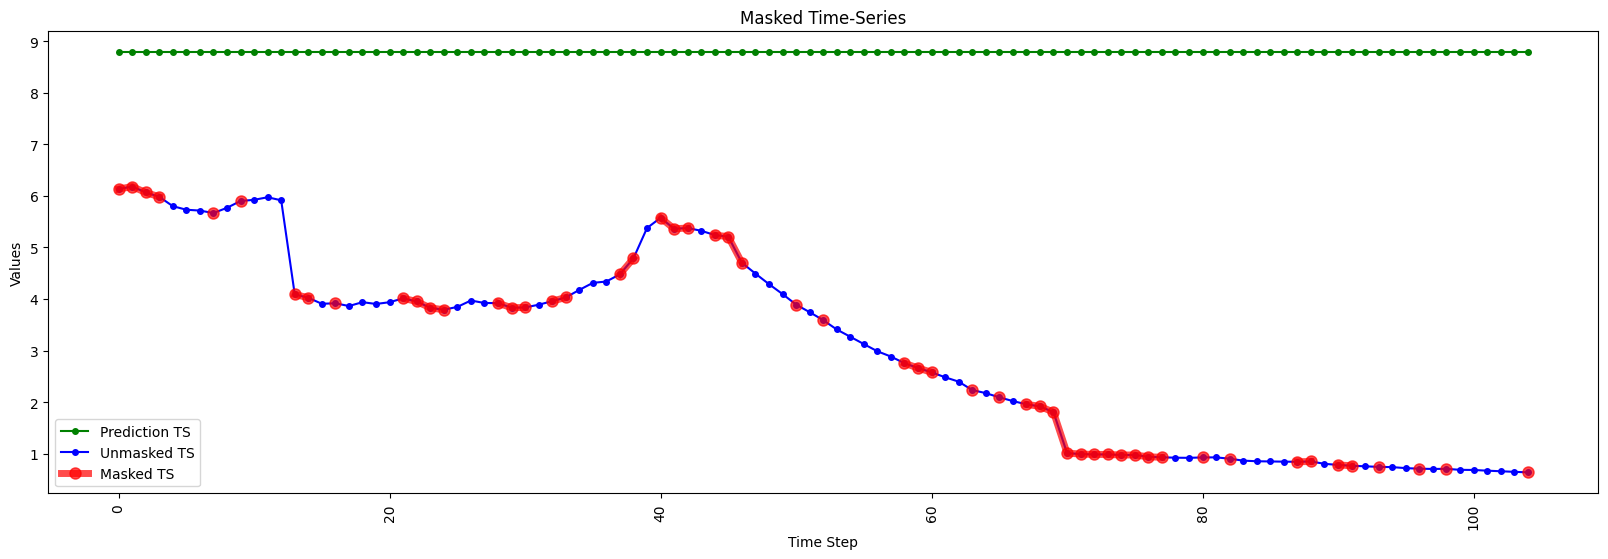

In [45]:
sample_index=[35*11, 35*12, 70*13]
plot_preds(val_X, predictions, masks, sample_index)

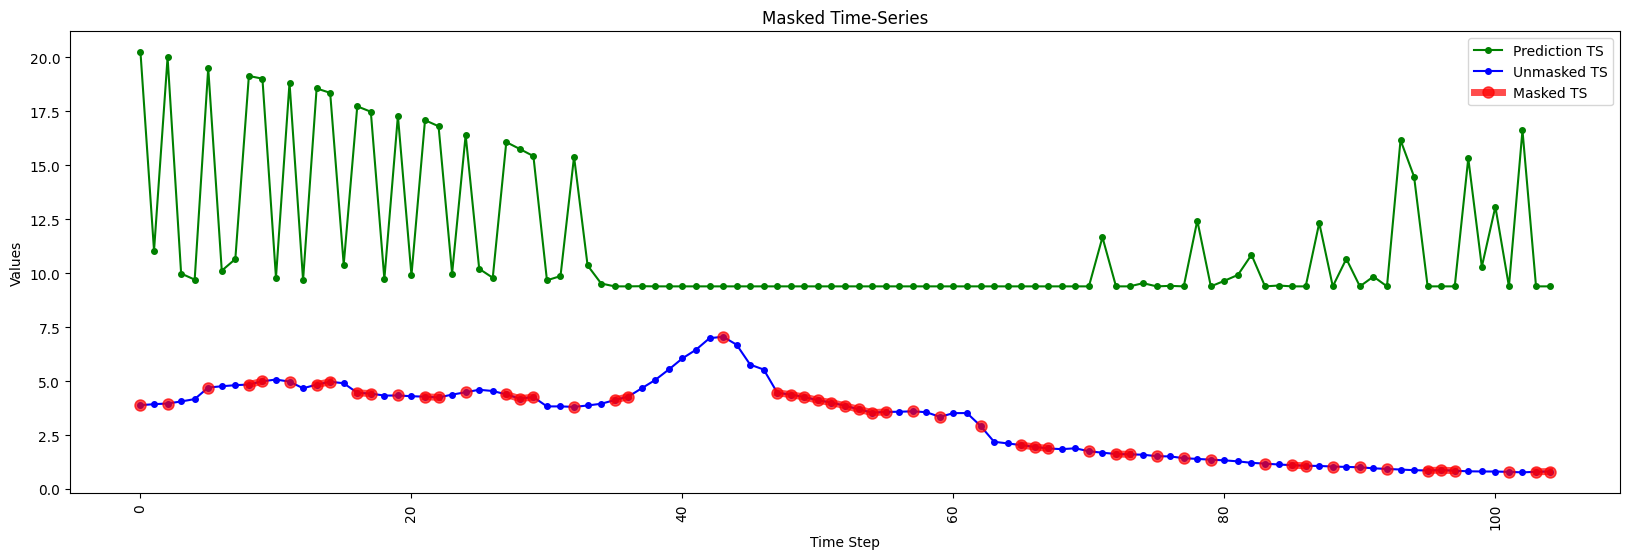

In [41]:
sample_index=[0, 35, 70]
plot_preds(val_X, predictions, masks, sample_index)

In [44]:
'''
rmse
'''
val_X = val_X.view(val_X.shape[0], val_X.shape[2], val_X.shape[1]).to(device)
predictions = predictions.to(device)

In [45]:
'''
rmse
'''
(((predictions-val_X)**2).mean())**0.5

tensor(29.4225, device='cuda:1')

In [46]:
'''
rmse
'''
(((predictions-val_X)**2).mean())**0.5

tensor(29.4225, device='cuda:1')

In [47]:
'''
TODO:

1. Add logs ->
    a. perform validation testing during training
    b. loss curves for training and validation
    c. log plots and loss curves (to see after which epoch the plots start to smoothen out)
    d. integrate weights and biases
2. perform 1-D reconstruction -> start training
4. get MSE error on validation data
5. do the same for n-D reconstruction and do a comparison
6. keep interpolated data points and see the number of samples
'''

'\nTODO:\n\n1. Add logs ->\n    a. perform validation testing during training\n    b. loss curves for training and validation\n    c. log plots and loss curves (to see after which epoch the plots start to smoothen out)\n    d. integrate weights and biases\n2. perform 1-D reconstruction -> start training\n4. get MSE error on validation data\n5. do the same for n-D reconstruction and do a comparison\n6. keep interpolated data points and see the number of samples\n'